# Mapping

In [263]:
#
# SPDX-FileCopyrightText: Copyright (c) 2021-2023 NVIDIA CORPORATION & AFFILIATES. All rights reserved.
# SPDX-License-Identifier: Apache-2.0
#
"""Layers for (de)mapping, constellation class, and utility functions"""

import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Layer
import matplotlib.pyplot as plt

import sionna as sn

def pam_gray(b):

    if len(b)>1:
        return (1-2*b[0])*(2**len(b[1:]) - pam_gray(b[1:]))
    return 1-2*b[0]

def qam(num_bits_per_symbol, normalize=True):

    try:
        assert num_bits_per_symbol % 2 == 0 # is even
        assert num_bits_per_symbol >0 # is larger than zero
    except AssertionError as error:
        raise ValueError("num_bits_per_symbol must be a multiple of 2") \
        from error
    assert isinstance(normalize, bool), "normalize must be boolean"

    # Build constellation by iterating through all points
    c = np.zeros([2**num_bits_per_symbol], dtype=np.complex64)
    for i in range(0, 2**num_bits_per_symbol):
        b = np.array(list(np.binary_repr(i,num_bits_per_symbol)),
                     dtype=np.int16)
        c[i] = pam_gray(b[0::2]) + 1j*pam_gray(b[1::2]) # PAM in each dimension

    if normalize: # Normalize to unit energy
        n = int(num_bits_per_symbol/2)
        qam_var = 1/(2**(n-2))*np.sum(np.linspace(1,2**n-1, 2**(n-1))**2)
        c /= np.sqrt(qam_var)
    return c

def pam(num_bits_per_symbol, normalize=True):

    try:
        assert num_bits_per_symbol >0 # is larger than zero
    except AssertionError as error:
        raise ValueError("num_bits_per_symbol must be positive") \
        from error
    assert isinstance(normalize, bool), "normalize must be boolean"

    # Build constellation by iterating through all points
    c = np.zeros([2**num_bits_per_symbol], dtype=np.float32)
    for i in range(0, 2**num_bits_per_symbol):
        b = np.array(list(np.binary_repr(i,num_bits_per_symbol)),
                     dtype=np.int16)
        c[i] = pam_gray(b)

    if normalize: # Normalize to unit energy
        n = int(num_bits_per_symbol)
        pam_var = 1/(2**(n-1))*np.sum(np.linspace(1,2**n-1, 2**(n-1))**2)
        c /= np.sqrt(pam_var)
    return c

class Constellation(Layer):

    def __init__(self,
                 constellation_type,
                 num_bits_per_symbol,
                 initial_value=None,
                 normalize=True,
                 center=False,
                 trainable=False,
                 dtype=tf.complex64,
                 **kwargs):
        super().__init__(**kwargs)
        assert dtype in [tf.complex64, tf.complex128],\
            "dtype must be tf.complex64 or tf.complex128"
        self._dtype = dtype

        assert constellation_type in ("qam", "pam", "custom"),\
            "Wrong constellation type"
        self._constellation_type = constellation_type

        assert isinstance(normalize, bool), "normalize must be boolean"
        self._normalize = normalize

        assert isinstance(center, bool), "center must be boolean"
        self._center = center

        assert isinstance(trainable, bool), "trainable must be boolean"
        self._trainable = trainable

        # allow float inputs that represent int
        assert isinstance(num_bits_per_symbol, (float,int)),\
            "num_bits_per_symbol must be integer"
        assert (num_bits_per_symbol%1==0),\
            "num_bits_per_symbol must be integer"
        num_bits_per_symbol = int(num_bits_per_symbol)

        if self._constellation_type=="qam":
            assert num_bits_per_symbol%2 == 0 and num_bits_per_symbol>0,\
                "num_bits_per_symbol must be a multiple of 2"
            self._num_bits_per_symbol = int(num_bits_per_symbol)

            assert initial_value is None, "QAM must not have an initial value"
            points = qam(self._num_bits_per_symbol, normalize=self.normalize)
            points = tf.cast(points, self._dtype)

        if self._constellation_type=="pam":
            assert num_bits_per_symbol>0,\
                "num_bits_per_symbol must be integer"
            self._num_bits_per_symbol = int(num_bits_per_symbol)

            assert initial_value is None, "PAM must not have an initial value"
            points = pam(self._num_bits_per_symbol, normalize=self.normalize)
            points = tf.cast(points, self._dtype)

        if self._constellation_type=="custom":
            assert num_bits_per_symbol>0,\
                "num_bits_per_symbol must be integer"
            self._num_bits_per_symbol = int(num_bits_per_symbol)

            # Randomly initialize points if no initial_value is provided
            if initial_value is None:
                points = tf.random.uniform(  # pylint: disable=E1123
                                        [2, 2**self._num_bits_per_symbol],
                                        minval=-0.05, maxval=0.05,
                                    dtype=tf.as_dtype(self._dtype).real_dtype)
                points  = tf.complex(points[0], points[1])
            else:
                assert tf.rank(initial_value).numpy() == 1
                assert tf.shape(initial_value)[0] == 2**num_bits_per_symbol,\
                    "initial_value must have shape [2**num_bits_per_symbol]"
                points = tf.cast(initial_value, self._dtype)
        self._points = points

    def build(self, input_shape): #pylint: disable=unused-argument
        points = self._points
        points = tf.stack([tf.math.real(points),
                           tf.math.imag(points)], axis=0)
        if self._trainable:
            self._points = tf.Variable(points,
                                       trainable=self._trainable,
                                    dtype=tf.as_dtype(self._dtype).real_dtype)
        else:
            self._points = tf.constant(points,
                                    dtype=tf.as_dtype(self._dtype).real_dtype)

    # pylint: disable=no-self-argument
    def create_or_check_constellation(  constellation_type=None,
                                        num_bits_per_symbol=None,
                                        constellation=None,
                                        dtype=tf.complex64):
        constellation_object = None
        if constellation is not None:
            assert constellation_type in [None, "custom"], \
                """`constellation_type` must be "custom"."""
            assert num_bits_per_symbol in \
                     [None, constellation.num_bits_per_symbol], \
                """`Wrong value of `num_bits_per_symbol.`"""
            assert constellation.dtype==dtype, \
                "Constellation has wrong dtype."
            constellation_object = constellation
        else:
            assert constellation_type in ["qam", "pam"], \
                "Wrong constellation type."
            assert num_bits_per_symbol is not None, \
                "`num_bits_per_symbol` must be provided."
            constellation_object = Constellation(   constellation_type,
                                                    num_bits_per_symbol,
                                                    dtype=dtype)
        return constellation_object

    def call(self, inputs): #pylint: disable=unused-argument
        x = self._points
        x = tf.complex(x[0], x[1])
        if self._center:
            x = x - tf.reduce_mean(x)
        if self._normalize:
            energy = tf.reduce_mean(tf.square(tf.abs(x)))
            energy_sqrt = tf.cast(tf.sqrt(energy), self._dtype)
            x = x / energy_sqrt
        return x

    @property
    def normalize(self):
        """Indicates if the constellation is normalized or not."""
        return self._normalize

    @normalize.setter
    def normalize(self, value):
        assert isinstance(value, bool), "`normalize` must be boolean"
        self._normalize = value

    @property
    def center(self):
        """Indicates if the constellation is centered."""
        return self._center

    @center.setter
    def center(self, value):
        assert isinstance(value, bool), "`center` must be boolean"
        self._center = value

    @property
    def num_bits_per_symbol(self):
        """The number of bits per constellation symbol."""
        return self._num_bits_per_symbol

    @property
    def points(self):
        """The (possibly) centered and normalized constellation points."""
        return self(None)

    def show(self, labels=True, figsize=(7,7)):

        maxval = np.max(np.abs(self.points))*1.05
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111)
        plt.xlim(-maxval, maxval)
        plt.ylim(-maxval, maxval)
        plt.scatter(np.real(self.points), np.imag(self.points))
        ax.set_aspect("equal", adjustable="box")
        plt.xlabel("Real Part")
        plt.ylabel("Imaginary Part")
        plt.grid(True, which="both", axis="both")
        plt.title("Constellation Plot")
        if labels is True:
            for j, p in enumerate(self.points.numpy()):
                plt.annotate(
                    np.binary_repr(j, self.num_bits_per_symbol),
                    (np.real(p), np.imag(p))
                )
        return fig

class Mapper(Layer):
    
    def __init__(self,
                 constellation_type=None,
                 num_bits_per_symbol=None,
                 constellation=None,
                 return_indices=False,
                 dtype=tf.complex64,
                 **kwargs
                ):
        super().__init__(dtype=dtype, **kwargs)
        assert dtype in [tf.complex64, tf.complex128],\
            "dtype must be tf.complex64 or tf.complex128"

        # Create constellation object
        self._constellation = Constellation.create_or_check_constellation(
                                                        constellation_type,
                                                        num_bits_per_symbol,
                                                        constellation,
                                                        dtype=dtype)

        self._return_indices = return_indices

        self._binary_base = 2**tf.constant(
                        range(self.constellation.num_bits_per_symbol-1,-1,-1))

    @property
    def constellation(self):
        """The Constellation used by the Mapper."""
        return self._constellation

    def call(self, inputs):
        tf.debugging.assert_greater_equal(tf.rank(inputs), 2,
            message="The input must have at least rank 2")

        # Reshape inputs to the desired format
        new_shape = [-1] + inputs.shape[1:-1].as_list() + \
           [int(inputs.shape[-1] / self.constellation.num_bits_per_symbol),
            self.constellation.num_bits_per_symbol]
        inputs_reshaped = tf.cast(tf.reshape(inputs, new_shape), tf.int32)

        # Convert the last dimension to an integer
        int_rep = tf.reduce_sum(inputs_reshaped * self._binary_base, axis=-1)

        # Map integers to constellation symbols
        x = tf.gather(self.constellation.points, int_rep, axis=0)

        if self._return_indices:
            return x, int_rep
        else:
            return x

class SymbolLogits2LLRs(Layer):
    
    def __init__(self,
                 method,
                 num_bits_per_symbol,
                 hard_out=False,
                 with_prior=False,
                 dtype=tf.float32,
                 **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        assert method in ("app","maxlog"), "Unknown demapping method"
        self._method = method
        self._hard_out = hard_out
        self._num_bits_per_symbol = num_bits_per_symbol
        self._with_prior = with_prior
        num_points = int(2**num_bits_per_symbol)

        # Array composed of binary representations of all symbols indices
        a = np.zeros([num_points, num_bits_per_symbol])
        for i in range(0, num_points):
            a[i,:] = np.array(list(np.binary_repr(i, num_bits_per_symbol)),
                              dtype=np.int16)

        # Compute symbol indices for which the bits are 0 or 1
        c0 = np.zeros([int(num_points/2), num_bits_per_symbol])
        c1 = np.zeros([int(num_points/2), num_bits_per_symbol])
        for i in range(num_bits_per_symbol-1,-1,-1):
            c0[:,i] = np.where(a[:,i]==0)[0]
            c1[:,i] = np.where(a[:,i]==1)[0]
        self._c0 = tf.constant(c0, dtype=tf.int32) # Symbols with ith bit=0
        self._c1 = tf.constant(c1, dtype=tf.int32) # Symbols with ith bit=1

        if with_prior:
            # Array of labels from {-1, 1} of all symbols
            # [num_points, num_bits_per_symbol]
            a = 2*a-1
            self._a = tf.constant(a, dtype=dtype)

        # Determine the reduce function for LLR computation
        if self._method == "app":
            self._reduce = tf.reduce_logsumexp
        else:
            self._reduce = tf.reduce_max

    @property
    def num_bits_per_symbol(self):
        return self._num_bits_per_symbol

    def call(self, inputs):
        if self._with_prior:
            logits, prior = inputs
        else:
            logits = inputs

        # Compute exponents
        exponents = logits

        # Gather exponents for all bits
        # shape [...,n,num_points/2,num_bits_per_symbol]
        exp0 = tf.gather(exponents, self._c0, axis=-1, batch_dims=0)
        exp1 = tf.gather(exponents, self._c1, axis=-1, batch_dims=0)

        # Process the prior information
        if self._with_prior:
            # Expanding `prior` such that it is broadcastable with
            # shape [..., n or 1, 1, num_bits_per_symbol]
            prior = sn.utils.expand_to_rank(prior, tf.rank(logits), axis=0)
            prior = tf.expand_dims(prior, axis=-2)

            # Expand the symbol labeling to be broadcastable with prior
            # shape [..., 1, num_points, num_bits_per_symbol]
            a = sn.utils.expand_to_rank(self._a, tf.rank(prior), axis=0)

            # Compute the prior probabilities on symbols exponents
            # shape [..., n or 1, num_points]
            exp_ps = tf.reduce_sum(tf.math.log_sigmoid(a*prior), axis=-1)

            # Gather prior probability symbol for all bits
            # shape [..., n or 1, num_points/2, num_bits_per_symbol]
            exp_ps0 = tf.gather(exp_ps, self._c0, axis=-1)
            exp_ps1 = tf.gather(exp_ps, self._c1, axis=-1)

        # Compute LLRs using the definition log( Pr(b=1)/Pr(b=0) )
        # shape [..., n, num_bits_per_symbol]
        if self._with_prior:
            llr = self._reduce(exp_ps1 + exp1, axis=-2)\
                    - self._reduce(exp_ps0 + exp0, axis=-2)
        else:
            llr = self._reduce(exp1, axis=-2) - self._reduce(exp0, axis=-2)

        if self._hard_out:
            return sn.utils.hard_decisions(llr)
        else:
            return llr

class SymbolLogits2LLRsWithPrior(SymbolLogits2LLRs):

    def __init__(self,
                 method,
                 num_bits_per_symbol,
                 hard_out=False,
                 dtype=tf.float32,
                 **kwargs):
        super().__init__(method=method,
                         num_bits_per_symbol=num_bits_per_symbol,
                         hard_out=False,
                         with_prior=True,
                         dtype=tf.float32,
                         **kwargs)

class Demapper(Layer):
    
    def __init__(self,
                 demapping_method,
                 constellation_type=None,
                 num_bits_per_symbol=None,
                 constellation=None,
                 hard_out=False,
                 with_prior=False,
                 dtype=tf.complex64,
                 **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        self._with_prior = with_prior


        # Create constellation object
        self._constellation = Constellation.create_or_check_constellation(
                                                        constellation_type,
                                                        num_bits_per_symbol,
                                                        constellation,
                                                        dtype=dtype)
        num_bits_per_symbol = self._constellation.num_bits_per_symbol

        self._logits2llrs = SymbolLogits2LLRs(demapping_method,
                                              num_bits_per_symbol,
                                              hard_out,
                                              with_prior,
                                              dtype.real_dtype,
                                              **kwargs)

    @property
    def constellation(self):
        return self._constellation

    def call(self, inputs):
        if self._with_prior:
            y, prior, no = inputs
        else:
            y, no = inputs

        # Reshape constellation points to [1,...1,num_points]
        points_shape = [1]*y.shape.rank + self.constellation.points.shape
        points = tf.reshape(self.constellation.points, points_shape)

        # Compute squared distances from y to all points
        # shape [...,n,num_points]
        squared_dist = tf.pow(tf.abs(tf.expand_dims(y, axis=-1) - points), 2)

        # Add a dummy dimension for broadcasting. This is not needed when no
        # is a scalar, but also does not do any harm.
        no = tf.expand_dims(no, axis=-1)

        # Compute exponents
        exponents = -squared_dist/no

        if self._with_prior:
            llr = self._logits2llrs([exponents, prior])
        else:
            llr = self._logits2llrs(exponents)

        # Reshape LLRs to [...,n*num_bits_per_symbol]
        out_shape = tf.concat([tf.shape(y)[:-1],
                               [y.shape[-1] * \
                                self.constellation.num_bits_per_symbol]], 0)
        llr_reshaped = tf.reshape(llr, out_shape)

        return llr_reshaped

class DemapperWithPrior(Demapper):
    
    def __init__(self,
                 demapping_method,
                 constellation_type=None,
                 num_bits_per_symbol=None,
                 constellation=None,
                 hard_out=False,
                 dtype=tf.complex64,
                 **kwargs):
        super().__init__(demapping_method=demapping_method,
                         constellation_type=constellation_type,
                         num_bits_per_symbol=num_bits_per_symbol,
                         constellation=constellation,
                         hard_out=hard_out,
                         with_prior=True,
                         dtype=dtype,
                         **kwargs)

class SymbolDemapper(Layer):
    
    def __init__(self,
                 constellation_type=None,
                 num_bits_per_symbol=None,
                 constellation=None,
                 hard_out=False,
                 with_prior=False,
                 dtype=tf.complex64,
                 **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        self._hard_out = hard_out
        self._with_prior = with_prior

        # Create constellation object
        self._constellation = Constellation.create_or_check_constellation(
                                                        constellation_type,
                                                        num_bits_per_symbol,
                                                        constellation,
                                                        dtype=dtype)

    def call(self, inputs):
        if self._with_prior:
            y, prior, no = inputs
        else:
            y, no = inputs

        points = sn.utils.expand_to_rank(self._constellation.points,
                                tf.rank(y)+1, axis=0)
        y = tf.expand_dims(y, axis=-1)
        d = tf.abs(y-points)

        no = sn.utils.expand_to_rank(no, tf.rank(d), axis=-1)
        exp = -d**2 / no

        if self._with_prior:
            prior = sn.utils.expand_to_rank(prior, tf.rank(exp), axis=0)
            exp = exp + prior

        if self._hard_out:
            return tf.argmax(exp, axis=-1, output_type=tf.int32)
        else:
            return tf.nn.log_softmax(exp, axis=-1)

class SymbolDemapperWithPrior(SymbolDemapper):
   
    def __init__(self,
                 constellation_type=None,
                 num_bits_per_symbol=None,
                 constellation=None,
                 hard_out=False,
                 dtype=tf.complex64,
                 **kwargs):
        super().__init__(constellation_type=constellation_type,
                         num_bits_per_symbol=num_bits_per_symbol,
                         constellation=constellation,
                         hard_out=hard_out,
                         with_prior=True,
                         dtype=dtype,
                         **kwargs)

class LLRs2SymbolLogits(Layer):

    def __init__(self,
                 num_bits_per_symbol,
                 hard_out=False,
                 dtype=tf.float32,
                 **kwargs):
        super().__init__(dtype=dtype, **kwargs)

        self._hard_out = hard_out
        self._num_bits_per_symbol = num_bits_per_symbol
        num_points = int(2**num_bits_per_symbol)

        # Array composed of binary representations of all symbols indices
        a = np.zeros([num_points, num_bits_per_symbol])
        for i in range(0, num_points):
            a[i,:] = np.array(list(np.binary_repr(i, num_bits_per_symbol)),
                              dtype=np.int16)

        # Array of labels from {-1, 1} of all symbols
        # [num_points, num_bits_per_symbol]
        a = 2*a-1
        self._a = tf.constant(a, dtype=dtype)

    @property
    def num_bits_per_symbol(self):
        return self._num_bits_per_symbol

    def call(self, inputs):
        llrs = inputs

        # Expand the symbol labeling to be broadcastable with prior
        # shape [1, ..., 1, num_points, num_bits_per_symbol]
        a = sn.utils.expand_to_rank(self._a, tf.rank(llrs), axis=0)

        # Compute the prior probabilities on symbols exponents
        # shape [..., 1, num_points]
        llrs = tf.expand_dims(llrs, axis=-2)
        logits = tf.reduce_sum(tf.math.log_sigmoid(a*llrs), axis=-1)

        if self._hard_out:
            return tf.argmax(logits, axis=-1, output_type=tf.int32)
        else:
            return logits

class SymbolLogits2Moments(Layer):
    
    def __init__(self,
                 constellation_type=None,
                 num_bits_per_symbol=None,
                 constellation=None,
                 dtype=tf.float32,
                 **kwargs):
        super().__init__(dtype=dtype, **kwargs)

        # Create constellation object
        const_dtype = tf.complex64 if dtype is tf.float32 else tf.complex128
        self._constellation = Constellation.create_or_check_constellation(
                                                        constellation_type,
                                                        num_bits_per_symbol,
                                                        constellation,
                                                        dtype=const_dtype)

    def __call__(self, logits):
        p = tf.math.softmax(logits, axis=-1)
        p_c = tf.complex(p, tf.cast(0.0, self.dtype))
        points = self._constellation.points
        points = sn.utils.expand_to_rank(points, tf.rank(p), axis=0)

        mean = tf.reduce_sum(p_c*points, axis=-1, keepdims=True)
        var = tf.reduce_sum(p*tf.square(tf.abs(points - mean)), axis=-1)
        mean = tf.squeeze(mean, axis=-1)

        return mean, var

class QAM2PAM:
    
    def __init__(self, num_bits_per_symbol):
        base = [2**i for i in range(num_bits_per_symbol//2-1, -1, -1)]
        base = np.array(base)
        pam1_ind = np.zeros([2**num_bits_per_symbol], dtype=np.int32)
        pam2_ind = np.zeros([2**num_bits_per_symbol], dtype=np.int32)
        for i in range(0, 2**num_bits_per_symbol):
            b = np.array(list(np.binary_repr(i,num_bits_per_symbol)),
                         dtype=np.int32)
            pam1_ind[i] = np.sum(b[0::2]*base)
            pam2_ind[i] = np.sum(b[1::2]*base)
        self._pam1_ind = tf.constant(pam1_ind, dtype=tf.int32)
        self._pam2_ind = tf.constant(pam2_ind, dtype=tf.int32)

    def __call__(self, ind_qam):

        ind_pam1 = tf.gather(self._pam1_ind, ind_qam, axis=0)
        ind_pam2 = tf.gather(self._pam2_ind, ind_qam, axis=0)

        return ind_pam1, ind_pam2

class PAM2QAM:
    
    def __init__(self, num_bits_per_symbol, hard_in_out=True):
        num_pam_symbols = 2**(num_bits_per_symbol//2)
        base = np.array([2**i for i in range(num_bits_per_symbol-1, -1, -1)])

        # Create an array of QAM symbol indices, index by two PAM indices
        ind = np.zeros([num_pam_symbols, num_pam_symbols], np.int32)
        for i in range(0, num_pam_symbols):
            for j in range(0, num_pam_symbols):
                b1 = np.array(list(np.binary_repr(i,num_bits_per_symbol//2)),
                              dtype=np.int16)
                b2 = np.array(list(np.binary_repr(j,num_bits_per_symbol//2)),
                              dtype=np.int16)
                b = np.zeros([num_bits_per_symbol], np.int32)
                b[0::2] = b1
                b[1::2] = b2
                ind[i, j] = np.sum(b*base)
        self._qam_ind = tf.constant(ind, dtype=tf.int32)
        self._hard_in_out = hard_in_out

    def __call__(self, pam1, pam2):

        # PAM indices to QAM indices
        if self._hard_in_out:
            shape = tf.shape(pam1)
            ind_pam1 = tf.reshape(pam1, [-1, 1])
            ind_pam2 = tf.reshape(pam2, [-1, 1])
            ind_pam = tf.concat([ind_pam1, ind_pam2], axis=-1)
            ind_qam = tf.gather_nd(self._qam_ind, ind_pam)
            ind_qam = tf.reshape(ind_qam, shape)
            return ind_qam

        # PAM logits to QAM logits
        else:
            # Compute all combination of sums of logits
            logits_mat = tf.expand_dims(pam1, -1) + tf.expand_dims(pam2, -2)

            # Flatten to a vector
            logits = sn.utils.flatten_last_dims(logits_mat)

            # Gather symbols in the correct order
            gather_ind = tf.reshape(self._qam_ind, [-1])
            logits = tf.gather(logits, gather_ind, axis=-1)
            return logits

class SymbolInds2Bits(Layer):
    
    def __init__(self,
               num_bits_per_symbol,
               dtype=tf.float32,
               **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        num_symbols = 2**num_bits_per_symbol
        b = np.zeros([num_symbols, num_bits_per_symbol])
        for i in range(0, num_symbols):
            b[i,:] = np.array(list(np.binary_repr(i, num_bits_per_symbol)),
                              dtype=np.int16)
        self._bit_labels = tf.constant(b, self.dtype)

    def call(self, inputs):
        symbol_ind = inputs
        return tf.gather(self._bit_labels, symbol_ind)
    



# ebnodb2no

In [ ]:
# Imports & Basics

# Import TensorFlow and NumPy
import tensorflow as tf
import numpy as np

# Import Sionna
try:
    import sionna as sn
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna as sn

# For plotting
%matplotlib inline
# also try %matplotlib widget

import matplotlib.pyplot as plt

# for performance measurements
import time

# For the implementation of the Keras models
from tensorflow.keras import Model

from sionna.utils.misc import hard_decisions
from sionna.utils.metrics import compute_ber, compute_ser

NUM_BITS_PER_SYMBOL = 4 # QPSK
BLOCK_LENGTH = 8
BATCH_SIZE = 2
EBN0_DB_MIN = -3.0
EBN0_DB_MAX = 3.0

for EBN0_DB in np.linspace(EBN0_DB_MIN,EBN0_DB_MAX,20):
    print('EBN0_DB =',EBN0_DB)
    no = sn.utils.ebnodb2no(ebno_db=EBN0_DB,
                            num_bits_per_symbol=NUM_BITS_PER_SYMBOL,
                            coderate=1.0)
    print('no =',no)


# AWGN (Additive White Gaussian **Noise**)

In [ ]:
# Imports & Basics

# Import TensorFlow and NumPy
import tensorflow as tf
import numpy as np

# Import Sionna
try:
    import sionna as sn
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna as sn

# For plotting
%matplotlib inline
# also try %matplotlib widget

import matplotlib.pyplot as plt

# for performance measurements
import time

# For the implementation of the Keras models
from tensorflow.keras import Model

from sionna.utils import expand_to_rank, complex_normal

NUM_BITS_PER_SYMBOL = 4 # QPSK
BLOCK_LENGTH = 8
BATCH_SIZE = 2
EBN0_DB = -10

# Binary source
binary_source = sn.utils.BinarySource()

bits = binary_source([BATCH_SIZE,BLOCK_LENGTH])
print('bits =\n',bits)

no = sn.utils.ebnodb2no(ebno_db=EBN0_DB,
                        num_bits_per_symbol=NUM_BITS_PER_SYMBOL,
                        coderate=1.0)
print('no =',no)

# Constellation
constellation = sn.mapping.Constellation("qam", NUM_BITS_PER_SYMBOL)
#constellation.show(figsize=(7,7));

# Mapper and Demapper
mapper = sn.mapping.Mapper(constellation=constellation)

x = mapper(bits)
print('x =\n',x)
 
# Create tensors of real-valued Gaussian noise for each complex dim.
noise = complex_normal(tf.shape(x), dtype=x.dtype)
print('noise =\n',noise)

# Add extra dimensions for broadcasting
no = expand_to_rank(no, tf.rank(x), axis=-1)
print('no =',no)

# Apply variance scaling
real_dtype = tf.dtypes.as_dtype(tf.complex64).real_dtype
no = tf.cast(no, real_dtype)
print('no =',no)
noise *= tf.cast(tf.sqrt(no), noise.dtype)
print('noise =\n',noise)

# Add noise to input
y = x + noise
#print('y = x + noise =\n',y)


# logits2llrs

In [ ]:
# Imports & Basics

# Import TensorFlow and NumPy
import tensorflow as tf
import numpy as np

# Import Sionna
try:
    import sionna as sn
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna as sn

# For plotting
%matplotlib inline
# also try %matplotlib widget

import matplotlib.pyplot as plt

# for performance measurements
import time

# For the implementation of the Keras models
from tensorflow.keras import Model

def SymbolLogits2LLRs(method, num_bits_per_symbol, hard_out=False, with_prior=False, dtype=tf.float32, **kwargs):
    # pylint: disable=line-too-long
    r"""
    SymbolLogits2LLRs(method, num_bits_per_symbol, hard_out=False, with_prior=False, dtype=tf.float32, **kwargs)

    Computes log-likelihood ratios (LLRs) or hard-decisions on bits
    from a tensor of logits (i.e., unnormalized log-probabilities) on constellation points.
    If the flag ``with_prior`` is set, prior knowledge on the bits is assumed to be available.

    Parameters
    ----------
    method : One of ["app", "maxlog"], str
        The method used for computing the LLRs.

    num_bits_per_symbol : int
        The number of bits per constellation symbol, e.g., 4 for QAM16.

    hard_out : bool
        If `True`, the layer provides hard-decided bits instead of soft-values.
        Defaults to `False`.

    with_prior : bool
        If `True`, it is assumed that prior knowledge on the bits is available.
        This prior information is given as LLRs as an additional input to the layer.
        Defaults to `False`.

    dtype : One of [tf.float32, tf.float64] tf.DType (dtype)
        The dtype for the input and output.
        Defaults to `tf.float32`.

    Input
    -----
    logits or (logits, prior):
        Tuple:

    logits : [...,n, num_points], tf.float
        Logits on constellation points.

    prior : [num_bits_per_symbol] or [...n, num_bits_per_symbol], tf.float
        Prior for every bit as LLRs.
        It can be provided either as a tensor of shape `[num_bits_per_symbol]`
        for the entire input batch, or as a tensor that is "broadcastable"
        to `[..., n, num_bits_per_symbol]`.
        Only required if the ``with_prior`` flag is set.

    Output
    ------
    : [...,n, num_bits_per_symbol], tf.float
        LLRs or hard-decisions for every bit.

    Note
    ----
    With the "app" method, the LLR for the :math:`i\text{th}` bit
    is computed according to

    .. math::
        LLR(i) = \ln\left(\frac{\Pr\left(b_i=1\lvert \mathbf{z},\mathbf{p}\right)}{\Pr\left(b_i=0\lvert \mathbf{z},\mathbf{p}\right)}\right) =\ln\left(\frac{
                \sum_{c\in\mathcal{C}_{i,1}} \Pr\left(c\lvert\mathbf{p}\right)
                e^{z_c}
                }{
                \sum_{c\in\mathcal{C}_{i,0}} \Pr\left(c\lvert\mathbf{p}\right)
                e^{z_c}
                }\right)

    where :math:`\mathcal{C}_{i,1}` and :math:`\mathcal{C}_{i,0}` are the
    sets of :math:`2^K` constellation points for which the :math:`i\text{th}` bit is
    equal to 1 and 0, respectively. :math:`\mathbf{z} = \left[z_{c_0},\dots,z_{c_{2^K-1}}\right]` is the vector of logits on the constellation points, :math:`\mathbf{p} = \left[p_0,\dots,p_{K-1}\right]`
    is the vector of LLRs that serves as prior knowledge on the :math:`K` bits that are mapped to
    a constellation point and is set to :math:`\mathbf{0}` if no prior knowledge is assumed to be available,
    and :math:`\Pr(c\lvert\mathbf{p})` is the prior probability on the constellation symbol :math:`c`:

    .. math::
        \Pr\left(c\lvert\mathbf{p}\right) = \prod_{k=0}^{K-1} \Pr\left(b_k = \ell(c)_k \lvert\mathbf{p} \right)
        = \prod_{k=0}^{K-1} \text{sigmoid}\left(p_k \ell(c)_k\right)

    where :math:`\ell(c)_k` is the :math:`k^{th}` bit label of :math:`c`, where 0 is
    replaced by -1.
    The definition of the LLR has been
    chosen such that it is equivalent with that of logits. This is
    different from many textbooks in communications, where the LLR is
    defined as :math:`LLR(i) = \ln\left(\frac{\Pr\left(b_i=0\lvert y\right)}{\Pr\left(b_i=1\lvert y\right)}\right)`.

    With the "maxlog" method, LLRs for the :math:`i\text{th}` bit
    are approximated like

    .. math::
        \begin{align}
            LLR(i) &\approx\ln\left(\frac{
                \max_{c\in\mathcal{C}_{i,1}} \Pr\left(c\lvert\mathbf{p}\right)
                    e^{z_c}
                }{
                \max_{c\in\mathcal{C}_{i,0}} \Pr\left(c\lvert\mathbf{p}\right)
                    e^{z_c}
                }\right)
                .
        \end{align}
    """
    def __init__(self,
                 method,
                 num_bits_per_symbol,
                 hard_out=False,
                 with_prior=False,
                 dtype=tf.float32,
                 **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        assert method in ("app","maxlog"), "Unknown demapping method"
        self._method = method
        self._hard_out = hard_out
        self._num_bits_per_symbol = num_bits_per_symbol
        self._with_prior = with_prior
        num_points = int(2**num_bits_per_symbol)

        # Array composed of binary representations of all symbols indices
        a = np.zeros([num_points, num_bits_per_symbol])
        for i in range(0, num_points):
            a[i,:] = np.array(list(np.binary_repr(i, num_bits_per_symbol)),
                              dtype=np.int16)

        # Compute symbol indices for which the bits are 0 or 1
        c0 = np.zeros([int(num_points/2), num_bits_per_symbol])
        c1 = np.zeros([int(num_points/2), num_bits_per_symbol])
        for i in range(num_bits_per_symbol-1,-1,-1):
            c0[:,i] = np.where(a[:,i]==0)[0]
            c1[:,i] = np.where(a[:,i]==1)[0]
        self._c0 = tf.constant(c0, dtype=tf.int32) # Symbols with ith bit=0
        self._c1 = tf.constant(c1, dtype=tf.int32) # Symbols with ith bit=1

        if with_prior:
            # Array of labels from {-1, 1} of all symbols
            # [num_points, num_bits_per_symbol]
            a = 2*a-1
            self._a = tf.constant(a, dtype=dtype)

        # Determine the reduce function for LLR computation
        if self._method == "app":
            self._reduce = tf.reduce_logsumexp
        else:
            self._reduce = tf.reduce_max

    @property
    def num_bits_per_symbol(self):
        return self._num_bits_per_symbol

    def call(self, inputs):
        if self._with_prior:
            logits, prior = inputs
        else:
            logits = inputs

        # Compute exponents
        exponents = logits

        # Gather exponents for all bits
        # shape [...,n,num_points/2,num_bits_per_symbol]
        exp0 = tf.gather(exponents, self._c0, axis=-1, batch_dims=0)
        exp1 = tf.gather(exponents, self._c1, axis=-1, batch_dims=0)

        # Process the prior information
        if self._with_prior:
            # Expanding `prior` such that it is broadcastable with
            # shape [..., n or 1, 1, num_bits_per_symbol]
            prior = sn.utils.expand_to_rank(prior, tf.rank(logits), axis=0)
            prior = tf.expand_dims(prior, axis=-2)

            # Expand the symbol labeling to be broadcastable with prior
            # shape [..., 1, num_points, num_bits_per_symbol]
            a = sn.utils.expand_to_rank(self._a, tf.rank(prior), axis=0)

            # Compute the prior probabilities on symbols exponents
            # shape [..., n or 1, num_points]
            exp_ps = tf.reduce_sum(tf.math.log_sigmoid(a*prior), axis=-1)

            # Gather prior probability symbol for all bits
            # shape [..., n or 1, num_points/2, num_bits_per_symbol]
            exp_ps0 = tf.gather(exp_ps, self._c0, axis=-1)
            exp_ps1 = tf.gather(exp_ps, self._c1, axis=-1)

        # Compute LLRs using the definition log( Pr(b=1)/Pr(b=0) )
        # shape [..., n, num_bits_per_symbol]
        if self._with_prior:
            llr = self._reduce(exp_ps1 + exp1, axis=-2)\
                    - self._reduce(exp_ps0 + exp0, axis=-2)
        else:
            llr = self._reduce(exp1, axis=-2) - self._reduce(exp0, axis=-2)

        if self._hard_out:
            return sn.utils.hard_decisions(llr)
        else:
            return llr

NUM_BITS_PER_SYMBOL = 4 # QPSK
BLOCK_LENGTH = 8
BATCH_SIZE = 2
EBN0_DB = -10

# Binary source
binary_source = sn.utils.BinarySource()

# Constellation
constellation = sn.mapping.Constellation("qam", NUM_BITS_PER_SYMBOL)
#constellation.show(figsize=(7,7));

# Mapper and Demapper
mapper = sn.mapping.Mapper(constellation=constellation)

# AWGN channel
awgn_channel = sn.channel.AWGN()

bits = binary_source([BATCH_SIZE,BLOCK_LENGTH])
#print('bits =\n',bits)

no = sn.utils.ebnodb2no(ebno_db=EBN0_DB,
                        num_bits_per_symbol=NUM_BITS_PER_SYMBOL,
                        coderate=1.0)
#print('no =',no)

x = mapper(bits)
#print('x =\n',x)

y = awgn_channel([x, no])

# Reshape constellation points to [1,...1,num_points]
points_shape = [1]*y.shape.rank + constellation.points.shape
points = tf.reshape(constellation.points, points_shape)

# Compute squared distances from y to all points
# shape [...,n,num_points]
squared_dist = tf.pow(tf.abs(tf.expand_dims(y, axis=-1) - points), 2)

# Add a dummy dimension for broadcasting. This is not needed when no
# is a scalar, but also does not do any harm.
no = tf.expand_dims(no, axis=-1)

# Compute exponents
exponents = -squared_dist/no
#print('exponents =\n',exponents)

logits2llrs = SymbolLogits2LLRs("app",NUM_BITS_PER_SYMBOL)
print('logits2llrs =\n',logits2llrs)

# if self._with_prior:
#     llr = self._logits2llrs([exponents, prior])
# else:
llr = logits2llrs(exponents)

# Reshape LLRs to [...,n*num_bits_per_symbol]
out_shape = tf.concat([tf.shape(y)[:-1],
                        [y.shape[-1] * \
                        constellation.num_bits_per_symbol]], 0)
llr_reshaped = tf.reshape(llr, out_shape)

# return llr_reshaped

# bits2symbol

## Test

In [ ]:
# Imports & Basics

# Import TensorFlow and NumPy
import tensorflow as tf
import numpy as np

# Import Sionna
try:
    import sionna as sn
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna as sn

# For plotting
%matplotlib inline
# also try %matplotlib widget

import matplotlib.pyplot as plt

# for performance measurements
import time

# For the implementation of the Keras models
from tensorflow.keras import Model

from sionna.utils.misc import hard_decisions
from sionna.utils.metrics import compute_ber, compute_ser

CODERATE = 0.5
n = 16
k = int(n*CODERATE)

NUM_BITS_PER_SYMBOL = 4 # QPSK
print('NUM_BITS_PER_SYMBOL =',NUM_BITS_PER_SYMBOL)
BLOCK_LENGTH = k
BATCH_SIZE = 2 # How many examples are processed by Sionna in parallel
EBN0_DB_MIN = -10.0 # Minimum value of Eb/N0 [dB] for simulations
EBN0_DB_MAX = 10.0 # Maximum value of Eb/N0 [dB] for simulations

# Binary source
binary_source = sn.utils.BinarySource()

# Constellation
constellation = sn.mapping.Constellation("qam", NUM_BITS_PER_SYMBOL)

bits = binary_source([BATCH_SIZE,BLOCK_LENGTH])
print('bits =\n',bits)

new_shape = [-1] + bits.shape[1:-1].as_list() + \
           [int(bits.shape[-1] / NUM_BITS_PER_SYMBOL),
            NUM_BITS_PER_SYMBOL]
print('new_shape =\n',new_shape)

bits_reshaped = tf.cast(tf.reshape(bits, new_shape), tf.int32)
print('symbols =\n',bits_reshaped)

binary_base = 2**tf.constant(
                        range(NUM_BITS_PER_SYMBOL-1,-1,-1))
print('binary_base =\n',binary_base)

int_rep = tf.reduce_sum(bits_reshaped * binary_base, axis=-1)
print('int_rep =\n',int_rep)

x = tf.gather(constellation.points, int_rep, axis=0)
print(x)

## Release

In [ ]:
# Imports & Basics

# Import TensorFlow and NumPy
import tensorflow as tf
import numpy as np

# Import Sionna
try:
    import sionna as sn
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna as sn

# For plotting
%matplotlib inline
# also try %matplotlib widget

import matplotlib.pyplot as plt

# for performance measurements
import time

# For the implementation of the Keras models
from tensorflow.keras import Model

from sionna.utils.misc import hard_decisions
from sionna.utils.metrics import compute_ber, compute_ser

def bits2symbol(bits,num_bits_per_symbol):
    new_shape = [-1] + bits.shape[1:-1].as_list() + \
            [int(bits.shape[-1] / NUM_BITS_PER_SYMBOL),
                NUM_BITS_PER_SYMBOL]
    #print('new_shape =',new_shape)
    #print('bits.shape[1:-1]',bits.shape[1:-1])
    # print('bits.shape[-1]=',bits.shape[-1])

    symbols = tf.cast(tf.reshape(bits, new_shape), tf.int32)
    # print('symbols =',symbols)
    return symbols


CODERATE = 0.5
n = 16
k = int(n*CODERATE)

NUM_BITS_PER_SYMBOL = 4 # QPSK
BLOCK_LENGTH = k
BATCH_SIZE = 2 # How many examples are processed by Sionna in parallel
EBN0_DB_MIN = -10.0 # Minimum value of Eb/N0 [dB] for simulations
EBN0_DB_MAX = 10.0 # Maximum value of Eb/N0 [dB] for simulations

# Binary source
binary_source = sn.utils.BinarySource()

# Constellation
constellation = sn.mapping.Constellation("qam", NUM_BITS_PER_SYMBOL)

#bits = binary_source([BATCH_SIZE,BLOCK_LENGTH])
bits = binary_source([2,3,4,5,6])
# print('bits =',bits)
# print('bits.ndim =',bits.ndim)

symbols = bits2symbol(bits,NUM_BITS_PER_SYMBOL)
# print('symbols =',symbols)

In [ ]:
# Import Sionna
try:
    import sionna as sn
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna as sn

import tensorflow as tf
import numpy as np
from sionna.utils import BinarySource, QAMSource, ebnodb2no, compute_ser, compute_ber, PlotBER
from sionna.channel import FlatFadingChannel, KroneckerModel
from sionna.channel.utils import exp_corr_mat
from sionna.mimo import lmmse_equalizer
from sionna.mapping import SymbolDemapper, Mapper, Demapper
from sionna.fec.ldpc.encoding import LDPC5GEncoder
from sionna.fec.ldpc.decoding import LDPC5GDecoder

BATCH_SIZE = 1000000
NUM_TX_ANT = 4
NUM_RX_ANT = 16
NUM_BITS_PER_SYMBOL = 4

channel = FlatFadingChannel(num_tx_ant=NUM_TX_ANT, num_rx_ant=NUM_RX_ANT, add_awgn=True, return_channel=True)
no = 0.2 # Noise variance of the channel
symbol_demapper = SymbolDemapper("qam", NUM_BITS_PER_SYMBOL, hard_out=True)
qam_source = QAMSource(num_bits_per_symbol=NUM_BITS_PER_SYMBOL)
x = qam_source([BATCH_SIZE, NUM_TX_ANT])
# print('x =',x)
# Get symbol indices for the transmitted symbols
x_ind = symbol_demapper([x, no])
# print('x_ind =',x_ind)

# Create transmit and receive correlation matrices
r_tx = exp_corr_mat(0.4, NUM_TX_ANT)
r_rx = exp_corr_mat(0.9, NUM_RX_ANT)

print('r_tx =',r_tx)
print('r_rx =',r_rx)
print('r_tx.shape =',r_tx.shape)
print('r_rx.shape =',r_rx.shape)

# Add the spatial correlation model to the channel
channel.spatial_corr = KroneckerModel(r_tx, r_rx)
#print('h_corr =',KroneckerModel(r_tx, r_rx))

h = channel.generate(BATCH_SIZE)
print('h.shape =',h.shape)

# Compute empirical covariance matrices
r_tx_hat = tf.reduce_mean(tf.matmul(h, h, adjoint_a=True), 0)/NUM_RX_ANT
r_rx_hat = tf.reduce_mean(tf.matmul(h, h, adjoint_b=True), 0)/NUM_TX_ANT

# Test that the empirical results match the theory
# assert(np.allclose(r_tx, r_tx_hat, atol=1e-2))
# assert(np.allclose(r_rx, r_rx_hat, atol=1e-2))

y, h = channel([x, no]) # type: ignore
s = tf.cast(no*tf.eye(NUM_RX_ANT, NUM_RX_ANT), y.dtype)
x_hat, no_eff = lmmse_equalizer(y, h, s)

# Get symbol indices for the received soft-symbols
x_ind_hat = symbol_demapper([x_hat, no])
compute_ser(x_ind, x_ind_hat)

# FlatFadingChannel

In [2]:
# Import Sionna
try:
    import sionna as sn
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna as sn

import tensorflow as tf
from tensorflow.keras.layers import Layer
from sionna.utils import expand_to_rank, complex_normal

from sionna.utils import BinarySource, QAMSource, ebnodb2no, compute_ser, compute_ber, PlotBER
from sionna.channel import FlatFadingChannel, KroneckerModel
from sionna.channel.utils import exp_corr_mat
from sionna.mimo import lmmse_equalizer, zf_equalizer
from sionna.mapping import SymbolDemapper, Mapper, Demapper
from sionna.fec.ldpc.encoding import LDPC5GEncoder
from sionna.fec.ldpc.decoding import LDPC5GDecoder
from sionna.utils.misc import hard_decisions
from sionna.utils.metrics import compute_ber

# from sionna.channel import AWGN
from sionna.utils import complex_normal

class AWGN(Layer):
    def __init__(self, dtype=tf.complex64, **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        self._real_dtype = tf.dtypes.as_dtype(self._dtype).real_dtype

    def call(self, inputs):

        x, no = inputs

        # Create tensors of real-valued Gaussian noise for each complex dim.
        noise = complex_normal(tf.shape(x), dtype=x.dtype)

        # Add extra dimensions for broadcasting
        no = expand_to_rank(no, tf.rank(x), axis=-1)

        # Apply variance scaling
        no = tf.cast(no, self._real_dtype)
        noise *= tf.cast(tf.sqrt(no), noise.dtype)
        print('noise shape =',noise.shape)
        # Add noise to input
        y = x + noise

        return y

class GenerateFlatFadingChannel():
    def __init__(self, num_tx_ant, num_rx_ant, spatial_corr=None, dtype=tf.complex64, **kwargs):
        super().__init__(**kwargs)
        self._num_tx_ant = num_tx_ant
        self._num_rx_ant = num_rx_ant
        self._dtype = dtype
        self.spatial_corr = spatial_corr
 
    @property
    def spatial_corr(self):
        """The :class:`~sionna.channel.SpatialCorrelation` to be used."""
        return self._spatial_corr
 
    @spatial_corr.setter
    def spatial_corr(self, value):
        self._spatial_corr = value
 
    def __call__(self, batch_size):
        # Generate standard complex Gaussian matrices
        shape = [batch_size, self._num_rx_ant, self._num_tx_ant]
        h = complex_normal(shape, dtype=self._dtype)
 
        # Apply spatial correlation
        if self.spatial_corr is not None:
            h = self.spatial_corr(h)
 
        return h

class ApplyFlatFadingChannel(tf.keras.layers.Layer):
    def __init__(self, add_awgn=True, dtype=tf.complex64, **kwargs):
        super().__init__(trainable=False, dtype=dtype, **kwargs)
        self._add_awgn = add_awgn
 
    def build(self, input_shape): #pylint: disable=unused-argument
        if self._add_awgn:
            self._awgn = AWGN(dtype=self.dtype)
 
    def call(self, inputs):
        if self._add_awgn:
            x, h, no = inputs
        else:
            x, h = inputs
 
        x = tf.expand_dims(x, axis=-1)
        print('x reshape(app_chn) =',x.shape)
        y = tf.matmul(h, x)
        y = tf.squeeze(y, axis=-1)
 
        if self._add_awgn:
            y = self._awgn((y, no))
 
        return y

class FlatFadingChannel(tf.keras.layers.Layer):
    def __init__(self,
                 num_tx_ant,
                 num_rx_ant,
                 spatial_corr=None,
                 add_awgn=True,
                 return_channel=False,
                 dtype=tf.complex64,
                 **kwargs):
        super().__init__(trainable=False, dtype=dtype, **kwargs)
        self._num_tx_ant = num_tx_ant
        self._num_rx_ant = num_rx_ant
        self._add_awgn = add_awgn
        self._return_channel = return_channel
        self._gen_chn = GenerateFlatFadingChannel(self._num_tx_ant,
                                                  self._num_rx_ant,
                                                  spatial_corr,
                                                  dtype=dtype)
        self._app_chn = ApplyFlatFadingChannel(add_awgn=add_awgn, dtype=dtype)
 
    @property
    def spatial_corr(self):
        """The :class:`~sionna.channel.SpatialCorrelation` to be used."""
        return self._gen_chn.spatial_corr
 
    @spatial_corr.setter
    def spatial_corr(self, value):
        self._gen_chn.spatial_corr = value
 
    @property
    def generate(self):
        """Calls the internal :class:`GenerateFlatFadingChannel`."""
        return self._gen_chn
 
    @property
    def apply(self):
        """Calls the internal :class:`ApplyFlatFadingChannel`."""
        return self._app_chn
 
    def call(self, inputs):
        if self._add_awgn:
            x, no = inputs
        else:
            x = inputs
 
        # Generate a batch of channel realizations
        batch_size = tf.shape(x)[0]
        print('batch_size =', batch_size)
        h = self._gen_chn(batch_size)
        print('h shape =',h.shape)
        print('h =',h)
 
        # Apply the channel to the input
        if self._add_awgn:
            y = self._app_chn([x, h, no])
        else:
            y = self._app_chn([x, h])
 
        if self._return_channel:
            return y, h
        else:
            return y

no = 0.2
NUM_BITS_PER_SYMBOL = 4 # 16 QAM
BATCH_SIZE = 32 # Parallel in 32 Batches
k = 512 # Message Bits
NUM_RX_ANT = 16 # Receiver Antennas
NUM_TX_ANT = 4 # Transmitter Antennas


# Constellation
constellation = sn.mapping.Constellation("qam", NUM_BITS_PER_SYMBOL)
#constellation.show(figsize=(7,7));

# Mapper and Demapper
mapper = sn.mapping.Mapper(constellation=constellation)
# The demapper uses the same constellation object as the mapper
demapper = sn.mapping.Demapper("app", constellation=constellation)

# Binary Source
binary_source = sn.utils.BinarySource()

# AWGN Channel
awgn_channel = sn.channel.AWGN()

# Flat Fading Channel
# To simulate transmissions over an i.i.d. Rayleigh fading channel. The channel will also add AWGN with variance `no`.
flatfading_channel = FlatFadingChannel(NUM_TX_ANT, NUM_RX_ANT, add_awgn=True, return_channel=True)
b = binary_source([BATCH_SIZE,NUM_TX_ANT,k])
print('b shape =',b.shape)

x = mapper(b)
print('x shape =',x.shape)

shape = tf.shape(x)
x_reshape = tf.reshape(x,[-1, NUM_TX_ANT])
print('x reshape =',x_reshape.shape)

y, h = flatfading_channel([x_reshape, no]) # type: ignore

b shape = (32, 4, 512)
x shape = (32, 4, 128)
x reshape = (4096, 4)
batch_size = tf.Tensor(4096, shape=(), dtype=int32)
h shape = (4096, 16, 4)
h = tf.Tensor(
[[[ 1.2106943 -0.57531357j -0.16533719+0.3895905j
   -0.1602286 +0.8083027j  -0.9215764 -0.03920262j]
  [-1.1231408 -0.76993793j  0.21325897+0.04296628j
   -0.5221998 +1.2066145j   1.3783945 -0.31628877j]
  [ 0.8965064 -0.12762327j -0.6455877 -0.3811652j
   -1.7724121 -0.19522943j  0.7525839 -0.42759407j]
  ...
  [ 0.6631029 -0.1177212j   0.280737  -0.14437845j
    0.84232557+0.22630343j  0.65941656-0.02572032j]
  [-0.6040951 -0.37555417j -0.6060022 -0.77499133j
   -0.71687335-0.30254802j  0.2920682 +0.11929827j]
  [ 1.7277184 +1.6393815j   0.53525054+0.6290777j
   -0.0562429 +0.52128416j -0.7860079 -1.0565555j ]]

 [[-0.7330225 +1.4971594j  -0.28901926+0.07351026j
   -0.5539348 +0.20673583j -0.60231996-0.3816234j ]
  [ 0.80606776-0.4482717j  -0.26762336+1.9391681j
   -0.39329344-0.33786756j -0.5783194 -0.268788j  ]
  [-0.3289001

# complex_normal

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.layers import Layer
def complex_normal(shape, var=1.0, dtype=tf.complex64):
    # Half the variance for each dimension
    var_dim = tf.cast(var, dtype.real_dtype)/tf.cast(2, dtype.real_dtype) # var_dim = 1/2
    print('var_dim =',var_dim)
    stddev = tf.sqrt(var_dim) # standard deviation = sqrt(variance) = sqrt(1/2) = 0.7071
    print('stddev =',stddev)
 
    # Generate complex Gaussian noise with the right variance
    xr = tf.random.normal(shape, stddev=stddev, dtype=dtype.real_dtype)
    xi = tf.random.normal(shape, stddev=stddev, dtype=dtype.real_dtype)
    x = tf.complex(xr, xi)
    print('x =',x)
 
    return x

shape = [4,3,2];
cn = complex_normal(shape);
print('cn shape=', cn.shape)

# equalization
# whiten_channel

In [ ]:
import tensorflow as tf
# For the implementation of the Keras models
from tensorflow import keras
from keras import Model
# for performance measurements
import time

# GPU Configuration and Imports
# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
gpus = tf.config.list_physical_devices('GPU')
print('Number of GPUs available :', len(gpus))
if gpus:
    gpu_num = 0 # Number of the GPU to be used
    try:
        tf.config.set_visible_devices(gpus[gpu_num], 'GPU')
        print('Only GPU number', gpu_num, 'used.')
        tf.config.experimental.set_memory_growth(gpus[gpu_num], True)
    except RuntimeError as e:
        print(e)

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sys

# Import Sionna
try:
    import sionna as sn
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna as sn
    
from sionna.utils import BinarySource, QAMSource, ebnodb2no, compute_ser, compute_ber, PlotBER
from sionna.channel import FlatFadingChannel, KroneckerModel
from sionna.channel.utils import exp_corr_mat
# from sionna.mimo import lmmse_equalizer, zf_equalizer
from sionna.mapping import SymbolDemapper, Mapper, Demapper
from sionna.fec.ldpc.encoding import LDPC5GEncoder
from sionna.fec.ldpc.decoding import LDPC5GDecoder
from sionna.utils.misc import hard_decisions
from sionna.utils.metrics import compute_ber
from sionna.utils import expand_to_rank, matrix_inv, matrix_pinv
# from sionna.mimo.utils import whiten_channel
from sionna.utils import matrix_sqrt_inv, expand_to_rank

def whiten_channel(y, h, s, return_s=True):
    # Compute whitening matrix
    s_inv_1_2 = matrix_sqrt_inv(s)
    s_inv_1_2 = expand_to_rank(s_inv_1_2, tf.rank(h), 0)

    # Whiten obervation and channel matrix
    yw = tf.expand_dims(y, -1)
    yw = tf.matmul(s_inv_1_2, yw)
    yw = tf.squeeze(yw, axis=-1)

    hw = tf.matmul(s_inv_1_2, h)

    if return_s:
        # Ideal interference covariance matrix after whitening
        sw = tf.eye(tf.shape(s)[-2], dtype=s.dtype)
        sw = expand_to_rank(sw, tf.rank(s), 0)
        return yw, hw, sw
    else:
        return yw, hw

def lmmse_equalizer(y, h, s, whiten_interference=True):
    if not whiten_interference:
        # Compute G (G = H^H(HH^H + S}^-1).
        print('H^H shape=',(np.linalg.pinv(h)).shape)
        g = tf.matmul(h, h, adjoint_b=True) + s
        print('H(H^H) shape=',(tf.matmul(h, h, adjoint_b=True)).shape)
        print('H(H^H)+S shape=',g.shape)
        print('(H(H^H)+S)^-1 shape',(matrix_inv(g)).shape)
        g = tf.matmul(h, matrix_inv(g), adjoint_a=True)
        print('H^H(H(H^H)+S)^-1 shape',g.shape)

    else:
        # Whiten channel
        y, h  = whiten_channel(y, h, s, return_s=False) # type: ignore

        # Compute G (G = ((H^H)H + i)^-1)H^H).
        print('h =',h)
        print('h^H =',np.linalg.pinv(h))
        # print('h^H shape=',(np.linalg.pinv(h)).shape)
        i = expand_to_rank(tf.eye(h.shape[-1], dtype=s.dtype), tf.rank(s), 0)
        print('i =',i)
        g = tf.matmul(h, h, adjoint_a=True) + i
        print('(h^H)h =',tf.matmul(h, h, adjoint_a=True))
        # print('(h^H)h shape=',(tf.matmul(h, h, adjoint_a=True)).shape)
        print('(h^H)h+i =',g)
        # print('(h^H)h+i shape=',g.shape)
        print('((h^H)h+i)^-1 =',matrix_inv(g))
        # print('((h^H)h+i)^-1 shape=',(matrix_inv(g)).shape)
        g = tf.matmul(matrix_inv(g), h, adjoint_b=True)
        print('(((h^H)h+i)^-1)h^H =',g)
        # print('(((h^H)H+i)^-1)h^H shape=',g.shape)

    # Compute Gy
    y = tf.expand_dims(y, -1)
    gy = tf.squeeze(tf.matmul(g, y), axis=-1)

    # Compute GH
    gh = tf.matmul(g, h)

    # Compute diag(GH)
    d = tf.linalg.diag_part(gh)

    # Compute x_hat (x_hat=(diag(GH)^-1)Gy)
    x_hat = gy/d

    # Compute residual error variance
    one = tf.cast(1, dtype=d.dtype)
    no_eff = tf.math.real(one/d - one)

    return x_hat, no_eff

def zf_equalizer(y, h, s):
    # Compute G
    g = matrix_pinv(h)

    # Compute x_hat
    y = tf.expand_dims(y, -1)
    x_hat = tf.squeeze(tf.matmul(g, y), axis=-1)

    # Compute residual error variance
    gsg = tf.matmul(tf.matmul(g, s), g, adjoint_b=True)
    no_eff = tf.math.real(tf.linalg.diag_part(gsg))

    return x_hat, no_eff

def mf_equalizer(y, h, s):
    # Compute G
    hth = tf.matmul(h, h, adjoint_a=True)
    d = tf.linalg.diag(tf.cast(1, h.dtype)/tf.linalg.diag_part(hth))
    g = tf.matmul(d, h, adjoint_b=True)

    # Compute x_hat
    y = tf.expand_dims(y, -1)
    x_hat = tf.squeeze(tf.matmul(g, y), axis=-1)

    # Compute residual error variance
    gsg = tf.matmul(tf.matmul(g, s), g, adjoint_b=True)
    gh = tf.matmul(g, h)
    i = expand_to_rank(tf.eye(gsg.shape[-2], dtype=gsg.dtype), tf.rank(gsg), 0)

    no_eff = tf.abs(tf.linalg.diag_part(tf.matmul(i-gh, i-gh, adjoint_b=True) + gsg))
    return x_hat, no_eff

# k = 512 # Block Length
# no = 0.2 # Noise variance of the channel
# NUM_TX_ANT = 4 # Transmit Antennas
# NUM_RX_ANT = 16 # Receive Antennas
# NUM_BITS_PER_SYMBOL = 4 # 16 QAM
# BATCH_SIZE = 8 # Parallelly Processed Batches
# EBN0_DB_MIN = -30.0 # Minimum Eb/N0 [dB]
# EBN0_DB_MAX = 10.0 # Maximum Eb/N0 [dB]
# snrs = []
# bers = []
# sers_zf = []
# sers_lmmse = []

k = 8 # Block Length
no = 0.2 # Noise variance of the channel
NUM_TX_ANT = 2 # Transmit Antennas
NUM_RX_ANT = 4 # Receive Antennas
NUM_BITS_PER_SYMBOL = 4 # 16 QAM
BATCH_SIZE = 1 # Parallelly Processed Batches
EBN0_DB_MIN = -30.0 # Minimum Eb/N0 [dB]
EBN0_DB_MAX = 10.0 # Maximum Eb/N0 [dB]
snrs = []
bers = []
sers_zf = []
sers_lmmse = []

# Binary Source
binary_source = sn.utils.BinarySource()

# Constellation
constellation = sn.mapping.Constellation("qam", NUM_BITS_PER_SYMBOL)
#constellation.show(figsize=(7,7));

# Mapper and Demapper
mapper = sn.mapping.Mapper(constellation=constellation)
# The demapper uses the same constellation object as the mapper
demapper = sn.mapping.Demapper("app", constellation=constellation)

# AWGN Channel
awgn_channel = sn.channel.AWGN()

# Flat Fading Channel
# To simulate transmissions over an i.i.d. Rayleigh fading channel. The channel will also add AWGN with variance `no`.
flatfading_channel = FlatFadingChannel(NUM_TX_ANT, NUM_RX_ANT, add_awgn=True, return_channel=True)

# SymbolDemapper
symbol_demapper = SymbolDemapper("qam", NUM_BITS_PER_SYMBOL, hard_out=True)

b = binary_source([BATCH_SIZE,NUM_TX_ANT,k])
print('b shape =',b.shape)

x = mapper(b)
print('x shape =',x.shape)

shape = tf.shape(x)
x_reshape = tf.reshape(x,[-1, NUM_TX_ANT])
print('x reshape =',x_reshape.shape)

y, h = flatfading_channel([x_reshape, no])
print('y shape =',y.shape)
# print('h =',h)
print('h shape =',h.shape)

s = tf.cast(no*tf.eye(NUM_RX_ANT, NUM_RX_ANT), y.dtype)
print('s =',s)
print('tf.rank(s) =',tf.rank(s))

x_hat_lmmse, no_eff_lmmse = lmmse_equalizer(y, h, s)
print('x_hat_lmmse.shape =',x_hat_lmmse.shape)
print('no_eff_lmmse shape =',no_eff_lmmse.shape)

noise_var_eff_lmmse = np.var(x_reshape-x_hat_lmmse)
noise_var_est_lmmse = np.mean(no_eff_lmmse)
print('noise_var_eff_lmmse =',noise_var_eff_lmmse)
print('noise_var_est_lmmse =',noise_var_est_lmmse)

plt.axes().set_aspect(1.0)
plt.scatter(np.real(x_hat_lmmse), np.imag(x_hat_lmmse))
plt.scatter(np.real(x), np.imag(x))

# SymbolDemapper

In [ ]:
# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
from tensorflow.keras.layers import Layer
gpus = tf.config.list_physical_devices('GPU')
print('Number of GPUs available :', len(gpus))
if gpus:
    gpu_num = 0 # Number of the GPU to be used
    try:
        tf.config.set_visible_devices(gpus[gpu_num], 'GPU')
        print('Only GPU number', gpu_num, 'used.')
        tf.config.experimental.set_memory_growth(gpus[gpu_num], True)
    except RuntimeError as e:
        print(e)

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sys

# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna

from sionna.utils import BinarySource, QAMSource, ebnodb2no, compute_ser, compute_ber, PlotBER
from sionna.channel import FlatFadingChannel, KroneckerModel
from sionna.channel.utils import exp_corr_mat
from sionna.mimo import lmmse_equalizer
# from sionna.mapping import SymbolDemapper
from sionna.mapping import Constellation, Mapper, Demapper
from sionna.fec.ldpc.encoding import LDPC5GEncoder
from sionna.fec.ldpc.decoding import LDPC5GDecoder

class SymbolDemapper(Layer):
    
    def __init__(self,
                 constellation_type=None,
                 num_bits_per_symbol=None,
                 constellation=None,
                 hard_out=False,
                 with_prior=False,
                 dtype=tf.complex64,
                 **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        self._hard_out = hard_out
        self._with_prior = with_prior
 
        # Create constellation object
        self._constellation = Constellation.create_or_check_constellation(
                                                        constellation_type,
                                                        num_bits_per_symbol,
                                                        constellation,
                                                        dtype=dtype)
 
    def call(self, inputs):
        if self._with_prior:
            y, prior, no = inputs
        else:
            y, no = inputs

        # print('y =',y)
        # print('y shape=',y.shape)
        # print('tf.rank(y) =',tf.rank(y))
        # print('tf.rank(y)+1 =',(tf.rank(y)+1))
        # print('self._constellation.points =',self._constellation.points)
        points = sn.utils.expand_to_rank(self._constellation.points,
                                tf.rank(y)+1, axis=0)
        # print('points =',points)
        # print('points shape=',points.shape)

        y = tf.expand_dims(y, axis=-1)
        # print('y =',y)
        # print('y shape=',y.shape)
        d = tf.abs(y-points)
        # print('d =',d)
        # print('d shape=',d.shape)
 
        no = sn.utils.expand_to_rank(no, tf.rank(d), axis=-1)
        # print('no =',no)
        # print('no shape=',no.shape)
        exp = -d**2 / no
        print('exp =',exp)
        # print('exp shape=',exp.shape)
 
        if self._with_prior:
            prior = sn.utils.expand_to_rank(prior, tf.rank(exp), axis=0)
            exp = exp + prior
 
        if self._hard_out:
            # tf.argmax: Get the Index of the maximum value in a tensor at the last dimension (axis=-1)
            print('tf.argmax(exp, axis=-1, output_type=tf.int32) =',tf.argmax(exp, axis=-1, output_type=tf.int32))
            # print('tf.argmax(exp, axis=-1, output_type=tf.int32) shape=',(tf.argmax(exp, axis=-1, output_type=tf.int32)).shape)
            return tf.argmax(exp, axis=-1, output_type=tf.int32)
        else:
            # print('tf.nn.log_softmax(exp, axis=-1) =',tf.nn.log_softmax(exp, axis=-1))
            print('tf.nn.log_softmax(exp, axis=-1) shape=',(tf.nn.log_softmax(exp, axis=-1)).shape)
            return tf.nn.log_softmax(exp, axis=-1)
        
num_tx_ant = 2
num_rx_ant = 4
num_bits_per_symbol = 4
batch_size = 3
qam_source = QAMSource(num_bits_per_symbol)
x = qam_source([batch_size, num_tx_ant])
print('x shape =',x.shape)

channel = FlatFadingChannel(num_tx_ant, num_rx_ant, add_awgn=True, return_channel=True)
no = 0.2 # Noise variance of the channel

# y and h are the channel output and channel realizations, respectively.
y, h = channel([x, no])
print('y shape =',y.shape)
print('h shape =',h.shape)

s = tf.cast(no*tf.eye(num_rx_ant, num_rx_ant), y.dtype)
x_hat, no_eff = lmmse_equalizer(y, h, s)
print('x_hat shape =',x_hat.shape)

plt.axes().set_aspect(1.0)
plt.scatter(np.real(x_hat), np.imag(x_hat));
plt.scatter(np.real(x), np.imag(x));

print('no_eff shape =',no_eff.shape)

noise_var_eff = np.var(x-x_hat)
noise_var_est = np.mean(no_eff)
print('noise_var_eff =',noise_var_eff)
print('noise_var_est =',noise_var_est)

symbol_demapper = SymbolDemapper("qam", num_bits_per_symbol, hard_out=True)

# Get symbol indices for the transmitted symbols
x_ind = symbol_demapper([x, no])

# # Get symbol indices for the received soft-symbols
# x_ind_hat = symbol_demapper([x_hat, no])

# compute_ser(x_ind, x_ind_hat)

# exp_corr_mat & KroneckerModel

In [ ]:
import tensorflow as tf
# For the implementation of the Keras models
from tensorflow.keras.layers import Layer
# for performance measurements
import time

# GPU Configuration and Imports
# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
gpus = tf.config.list_physical_devices('GPU')
print('Number of GPUs available :', len(gpus))
if gpus:
    gpu_num = 0 # Number of the GPU to be used
    try:
        tf.config.set_visible_devices(gpus[gpu_num], 'GPU')
        print('Only GPU number', gpu_num, 'used.')
        tf.config.experimental.set_memory_growth(gpus[gpu_num], True)
    except RuntimeError as e:
        print(e)

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sys

# Import Sionna
try:
    import sionna as sn
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna as sn
    
from sionna.utils import BinarySource, QAMSource, ebnodb2no, compute_ser, compute_ber, PlotBER
# from sionna.channel import FlatFadingChannel, KroneckerModel
from sionna.channel import FlatFadingChannel, SpatialCorrelation
# from sionna.channel.utils import exp_corr_mat
from sionna.mimo import lmmse_equalizer, zf_equalizer
from sionna.mapping import SymbolDemapper, Mapper, Demapper
from sionna.fec.ldpc.encoding import LDPC5GEncoder
from sionna.fec.ldpc.decoding import LDPC5GDecoder
from sionna.utils.misc import hard_decisions
from sionna.utils.metrics import compute_ber
from sionna.utils import expand_to_rank, matrix_sqrt

def exp_corr_mat(a, n, dtype=tf.complex64):

    # Cast to desired output dtype and expand last dimension for broadcasting
    a = tf.cast(a, dtype=dtype)
    a = tf.expand_dims(a, -1)
 
    # Check that a is valid
    msg = "The absolute value of the elements of `a` must be smaller than one"
    tf.debugging.assert_less(tf.abs(a), tf.cast(1, a.dtype.real_dtype), msg)
 
    # Vector of exponents, adapt dtype and dimensions for broadcasting
    exp = tf.range(0, n)
    exp = tf.cast(exp, dtype=dtype)
    exp = expand_to_rank(exp, tf.rank(a), 0)
 
    # First column of R
    col = tf.math.pow(a, exp)
 
    # For a=0, one needs to remove the resulting nans due to 0**0=nan
    cond = tf.math.is_nan(tf.math.real(col))
    col = tf.where(cond, tf.ones_like(col), col)
 
    # First row of R (equal to complex-conjugate of the first column)
    row = tf.math.conj(col)
 
    # Create Toeplitz operator
    operator = tf.linalg.LinearOperatorToeplitz(col, row)
 
    # Generate dense tensor from operator
    r = operator.to_dense()
 
    return r

class KroneckerModel(SpatialCorrelation):
    def __init__(self, r_tx=None, r_rx=None):
        super().__init__()
        self.r_tx = r_tx
        self.r_rx = r_rx
 
    @property
    def r_tx(self):
        return self._r_tx
 
    @r_tx.setter
    def r_tx(self, value):
        self._r_tx = value
        if self._r_tx is not None:
            self._r_tx_sqrt = matrix_sqrt(value)
        else:
            self._r_tx_sqrt = None
 
    @property
    def r_rx(self):
        return self._r_rx
 
    @r_rx.setter
    def r_rx(self, value):
        self._r_rx = value
        if self._r_rx is not None:
            self._r_rx_sqrt = matrix_sqrt(value)
        else:
            self._r_rx_sqrt = None
 
    def __call__(self, h):
        if self._r_tx_sqrt is not None:
            r_tx_sqrt = expand_to_rank(self._r_tx_sqrt, tf.rank(h), 0)
            h = tf.matmul(h, r_tx_sqrt, adjoint_b=True)
 
        if self._r_rx_sqrt is not None:
            r_rx_sqrt = expand_to_rank(self._r_rx_sqrt, tf.rank(h), 0)
            h = tf.matmul(r_rx_sqrt, h)
        # print('h =',h)
        return h

k = 512 # Block Length
no = 0.2 # Noise variance of the channel
NUM_TX_ANT = 4 # Transmit Antennas
NUM_RX_ANT = 4 # Receive Antennas
NUM_BITS_PER_SYMBOL = 4 # 16 QAM
BATCH_SIZE = 1024 # Parallelly Processed Batches
EBN0_DB_MIN = -30.0 # Minimum Eb/N0 [dB]
EBN0_DB_MAX = 10.0 # Maximum Eb/N0 [dB]
snrs = []
bers = []
sers_zf = []
sers_lmmse = []

# Binary Source
binary_source = sn.utils.BinarySource()

# Constellation
constellation = sn.mapping.Constellation("qam", NUM_BITS_PER_SYMBOL)
#constellation.show(figsize=(7,7));

# Mapper and Demapper
mapper = sn.mapping.Mapper(constellation=constellation)
# The demapper uses the same constellation object as the mapper
demapper = sn.mapping.Demapper("app", constellation=constellation)

# AWGN Channel
awgn_channel = sn.channel.AWGN()

# Flat Fading Channel
# To simulate transmissions over an i.i.d. Rayleigh fading channel. The channel will also add AWGN with variance `no`.
flatfading_channel = FlatFadingChannel(NUM_TX_ANT, NUM_RX_ANT, add_awgn=True, return_channel=True)

# SymbolDemapper
symbol_demapper = SymbolDemapper("qam", NUM_BITS_PER_SYMBOL, hard_out=True)

b = binary_source([BATCH_SIZE,NUM_TX_ANT,k])
print('b shape =',b.shape)

x = mapper(b)
print('x shape =',x.shape)

x_ind = symbol_demapper([x, no])
print('x_ind shape',x_ind.shape)

shape = tf.shape(x)
x_reshape = tf.reshape(x,[-1, NUM_TX_ANT])
print('x reshape =',x_reshape.shape)

# Adding Spatial Correlation
# Create transmit and receive correlation matrices
r_tx = exp_corr_mat(0.1, NUM_TX_ANT)
r_rx = exp_corr_mat(0.1, NUM_RX_ANT)
print('r_tx =',r_tx)
print('r_rx =',r_rx)

# Add the spatial correlation model to the channel
flatfading_channel.spatial_corr = KroneckerModel(r_tx, r_rx)

y, h = flatfading_channel([x_reshape, no])
print('y shape =',y.shape)
# print('h =',h)
print('h shape =',h.shape)

# Compute empirical covariance matrices
r_tx_hat = tf.reduce_mean(tf.matmul(h, h, adjoint_a=True), 0)/NUM_RX_ANT
r_rx_hat = tf.reduce_mean(tf.matmul(h, h, adjoint_b=True), 0)/NUM_TX_ANT

# Test that the empirical results match the theory
assert(np.allclose(r_tx, r_tx_hat, atol=1e-2))
assert(np.allclose(r_rx, r_rx_hat, atol=1e-2))

s = tf.cast(no*tf.eye(NUM_RX_ANT, NUM_RX_ANT), y.dtype)

x_hat_lmmse, no_eff_lmmse = lmmse_equalizer(y, h, s)
print('x_hat_lmmse.shape =',x_hat_lmmse.shape)
print('no_eff_lmmse shape =',no_eff_lmmse.shape)

# Confirm the correctness of estimate x by comparing 
# the average estimated effective noise variance between 
# the transmitted and equalized symbols.
noise_var_eff_lmmse = np.var(x_reshape-x_hat_lmmse)
noise_var_est_lmmse = np.mean(no_eff_lmmse)
# print('noise_var_eff_lmmse =',noise_var_eff_lmmse)
# print('noise_var_est_lmmse =',noise_var_est_lmmse)

x_hat_lmmse = tf.reshape(x_hat_lmmse, shape)

x_ind_hat_lmmse = symbol_demapper([x_hat_lmmse, no])
print('x_ind_hat_lmmse shape',x_ind_hat_lmmse.shape)

print('SER =',compute_ser(x_ind, x_ind_hat_lmmse))

plt.axes().set_aspect(1.0)
plt.scatter(np.real(x_hat_lmmse), np.imag(x_hat_lmmse))
plt.scatter(np.real(x), np.imag(x))

# DeepImagePrior

In [1]:
import torch
from torch import nn
# from myDIP import DeepImagePrior, Decoder, EarlyStop

import tensorflow as tf
# For the implementation of the Keras models
from tensorflow.keras.layers import Layer
# for performance measurements
import time

# GPU Configuration and Imports
# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
gpus = tf.config.list_physical_devices('GPU')
print('Number of GPUs available :', len(gpus))
if gpus:
    gpu_num = 0 # Number of the GPU to be used
    try:
        tf.config.set_visible_devices(gpus[gpu_num], 'GPU')
        print('Only GPU number', gpu_num, 'used.')
        tf.config.experimental.set_memory_growth(gpus[gpu_num], True)
    except RuntimeError as e:
        print(e)

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sys

# Import Sionna
try:
    import sionna as sn
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna as sn
    
from sionna.utils import BinarySource, QAMSource, ebnodb2no, compute_ser, compute_ber, PlotBER
from sionna.channel import FlatFadingChannel, KroneckerModel
from sionna.channel.utils import exp_corr_mat
from sionna.mimo import lmmse_equalizer, zf_equalizer
from sionna.mapping import SymbolDemapper, Mapper, Demapper
from sionna.fec.ldpc.encoding import LDPC5GEncoder
from sionna.fec.ldpc.decoding import LDPC5GDecoder
from sionna.utils.misc import hard_decisions
from sionna.utils.metrics import compute_ber
from xyDIP import DeepImagePrior

k = 8 # Block Length：512
# no = 0.2 # Noise variance of the channel
NUM_TX_ANT = 4 # Transmit Antennas
NUM_RX_ANT = 16 # Receive Antennas
NUM_BITS_PER_SYMBOL = 4 # 16 QAM
BATCH_SIZE = 1 # Parallelly Processed Batches: 32
EBN0_DB_MIN = -25.0 # Minimum Eb/N0 [dB]
EBN0_DB_MAX = 25.0 # Maximum Eb/N0 [dB]
TX_ANT_CORRELATION_INDEX = 0
RX_ANT_CORRELATION_INDEX = 0
CORRELATION_INDEX_MIN = 0.1
CORRELATION_INDEX_MAX = 0.9
snrs = np.linspace(EBN0_DB_MIN,EBN0_DB_MAX,51)
# print('snrs[25] =',snrs[25])
bers = []
sers_zf = np.zeros((9, 51))
sers_lmmse = np.zeros((9, 51))
i = 0
j = 0

# Binary Source
binary_source = sn.utils.BinarySource()

# Constellation
constellation = sn.mapping.Constellation("qam", NUM_BITS_PER_SYMBOL)
#constellation.show(figsize=(7,7));

# Mapper and Demapper
mapper = sn.mapping.Mapper(constellation=constellation)
# The demapper uses the same constellation object as the mapper
demapper = sn.mapping.Demapper("app", constellation=constellation)

# AWGN Channel
awgn_channel = sn.channel.AWGN()

# Flat Fading Channel
# To simulate transmissions over an i.i.d. Rayleigh fading channel. The channel will also add AWGN with variance `no`.
flatfading_channel = FlatFadingChannel(NUM_TX_ANT, NUM_RX_ANT, add_awgn=True, return_channel=True)

# SymbolDemapper
symbol_demapper = SymbolDemapper("qam", NUM_BITS_PER_SYMBOL, hard_out=True)

# Deep Image Prior
dip = DeepImagePrior(user_num=NUM_RX_ANT,      # Number of transmitted symbol in real domain
                    M=16,              # Modulation order, 4 for 4QAM, 16 for 16QAM; 16QAM: 4 bits per symbol
                    iteration=100,    # Number of max iterations used for DIP: 100
                    LR=0.01,          # Learning rate,  typically set to 0.01
                    buffer_size=30,   # Iterations stored,  typically set to 30
                    threshold=0.001,  # Threshold of DIP stop,, typically set to 0.001
                    stop=True)        # True

b = binary_source([BATCH_SIZE,NUM_TX_ANT,k])
print('b shape =',b.shape)
print('b =',b)

x = mapper(b)
print('x shape =',x.shape)
print('x =',x)

shape = tf.shape(x)
x_reshape = tf.reshape(x,[-1, NUM_TX_ANT])
print('x reshape =',x_reshape.shape)
# print('x_reshape =',x_reshape)

# Tx_Symbols = bits2symbol(b,NUM_BITS_PER_SYMBOL)
# print('Tx_Symbols =',Tx_Symbols)

# # Adding Spatial Correlation
# # Create transmit and receive correlation matrices
# r_tx = exp_corr_mat(TX_ANT_CORRELATION_INDEX, NUM_TX_ANT)
# r_rx = exp_corr_mat(RX_ANT_CORRELATION_INDEX, NUM_RX_ANT)
# # print('r_tx =',r_tx)
# # print('r_rx =',r_rx)

# # Add the spatial correlation model to the channel
# flatfading_channel.spatial_corr = KroneckerModel(r_tx, r_rx)

for TX_ANT_CORRELATION_INDEX in np.linspace(CORRELATION_INDEX_MIN,CORRELATION_INDEX_MAX,3):
    r_tx = exp_corr_mat(TX_ANT_CORRELATION_INDEX, NUM_TX_ANT)
    for RX_ANT_CORRELATION_INDEX in np.linspace(CORRELATION_INDEX_MIN,CORRELATION_INDEX_MAX,3):
        print('TX_ANT_CORRELATION_INDEX =',TX_ANT_CORRELATION_INDEX)
        print('RX_ANT_CORRELATION_INDEX =',RX_ANT_CORRELATION_INDEX)
        r_rx = exp_corr_mat(RX_ANT_CORRELATION_INDEX, NUM_RX_ANT)
        flatfading_channel.spatial_corr = KroneckerModel(r_tx, r_rx)
        if i == 0:
            LINE_COLOR_ZF = 'red'
            LINE_MARKER_ZF = 'o'
            LINE_STYLE_ZF = '-'
            LINE_COLOR_LMMSE = 'lawngreen'
            LINE_MARKER_LMMSE = '>'
            LINE_STYLE_LMMSE = '--'
        elif i == 1:
            LINE_COLOR_ZF = 'orange'
            LINE_MARKER_ZF = 'o'
            LINE_STYLE_ZF = '-'
            LINE_COLOR_LMMSE = 'deepskyblue'
            LINE_MARKER_LMMSE = '>'
            LINE_STYLE_LMMSE = '-.'
        elif i == 2:
            LINE_COLOR_ZF = 'chocolate'
            LINE_MARKER_ZF = 'o'
            LINE_STYLE_ZF = '-'
            LINE_COLOR_LMMSE = 'dodgerblue'
            LINE_MARKER_LMMSE = '>'
            LINE_STYLE_LMMSE = '--'
        elif i == 3:
            LINE_COLOR_ZF = 'goldenrod'
            LINE_MARKER_ZF = 'o'
            LINE_STYLE_ZF = '-'
            LINE_COLOR_LMMSE = 'darkorchid'
            LINE_MARKER_LMMSE = '>'
            LINE_STYLE_LMMSE = '-.'
        elif i == 4:
            LINE_COLOR_ZF = 'springgreen'
            LINE_MARKER_ZF = 'o'
            LINE_STYLE_ZF = '-'
            LINE_COLOR_LMMSE = 'fuchsia'
            LINE_MARKER_LMMSE = '>'
            LINE_STYLE_LMMSE = '--'
        elif i == 5:
            LINE_COLOR_ZF = 'black'
            LINE_MARKER_ZF = 'o'
            LINE_STYLE_ZF = '-'
            LINE_COLOR_LMMSE = 'gold'
            LINE_MARKER_LMMSE = '>'
            LINE_STYLE_LMMSE = '-.'
        elif i == 6:
            LINE_COLOR_ZF = 'brown'
            LINE_MARKER_ZF = 'o'
            LINE_STYLE_ZF = '-'
            LINE_COLOR_LMMSE = 'darkcyan'
            LINE_MARKER_LMMSE = '>'
            LINE_STYLE_LMMSE = '--'
        elif i == 7:
            LINE_COLOR_ZF = 'darkorange'
            LINE_MARKER_ZF = 'o'
            LINE_STYLE_ZF = '-'
            LINE_COLOR_LMMSE = 'crimson'
            LINE_MARKER_LMMSE = '>'
            LINE_STYLE_LMMSE = '-.'
        else:
            LINE_COLOR_ZF = 'olive'
            LINE_MARKER_ZF = 'o'
            LINE_STYLE_ZF = '-'
            LINE_COLOR_LMMSE = 'lightcoral'
            LINE_MARKER_LMMSE = '>'
            LINE_STYLE_LMMSE = '--'

        for EBN0_DB in np.linspace(EBN0_DB_MIN,EBN0_DB_MAX,1): # 51

            # snrs += [EBN0_DB]

            no = sn.utils.ebnodb2no(ebno_db=EBN0_DB,
                                    num_bits_per_symbol=NUM_BITS_PER_SYMBOL,
                                    coderate=1.0) # Coderate set to 1 as we do uncoded transmission here
            # print('no =',no)

            x_ind = symbol_demapper([x, no])
            # print('x_ind.shape =',x_ind.shape)
            # print('x_ind =',x_ind)

            # y and h are the Channel Output and Channel Realizations, respectively.
            y, h = flatfading_channel([x_reshape, no])
            print('h.shape =\n',h.shape)
            # print('h =',h)
            print('y.shape =\n',y.shape)
            # print('y =',y)

            # Compute empirical covariance matrices
            r_tx_hat = tf.reduce_mean(tf.matmul(h, h, adjoint_a=True), 0)/NUM_RX_ANT
            r_rx_hat = tf.reduce_mean(tf.matmul(h, h, adjoint_b=True), 0)/NUM_TX_ANT

            # # Test that the empirical results match the theory
            # assert(np.allclose(r_tx, r_tx_hat, atol=1e-2))
            # assert(np.allclose(r_rx, r_rx_hat, atol=1e-2))

            s = tf.cast(no*tf.eye(NUM_RX_ANT, NUM_RX_ANT), y.dtype)

            x_hat_zf, no_eff_zf = zf_equalizer(y, h, s)
            # print('x_hat_zf.shape =',x_hat_zf.shape)
            x_hat_lmmse, no_eff_lmmse = lmmse_equalizer(y, h, s)
            # print('x_hat_lmmse.shape =',x_hat_lmmse.shape)

            x_dip_ay,num_stop_point = dip.DIP(y,h)
            print('x_dip_ay.shape =',x_dip_ay.shape)
            print('x_dip_ay =',x_dip_ay)
            print('num_stop_point =',num_stop_point)

            # Confirm the correctness of estimate x by comparing 
            # the average estimated effective noise variance between 
            # the transmitted and equalized symbols.
            noise_var_eff_zf = np.var(x_reshape-x_hat_zf)
            noise_var_est_zf = np.mean(no_eff_zf)
            noise_var_eff_lmmse = np.var(x_reshape-x_hat_lmmse)
            noise_var_est_lmmse = np.mean(no_eff_lmmse)
            # print('noise_var_eff_lmmse =',noise_var_eff_lmmse)
            # print('noise_var_est_lmmse =',noise_var_est_lmmse)

            x_hat_zf = tf.reshape(x_hat_zf, shape)
            # print('x_hat_zf.shape =',x_hat_zf.shape)
            x_hat_lmmse = tf.reshape(x_hat_lmmse, shape)
            # print('x_hat_lmmse.shape =',x_hat_lmmse.shape)

            no_eff_zf = tf.reshape(no_eff_zf, shape)
            # print('no_eff_zf.shape =',no_eff_zf.shape)
            no_eff_lmmse = tf.reshape(no_eff_lmmse, shape)
            # print('no_eff_lmmse.shape =',no_eff_lmmse.shape)

            # llr_zf = demapper([x_hat_zf, no_eff_zf])
            # b_hat_zf = decoder(llr_zf)

            x_ind_hat_zf = symbol_demapper([x_hat_zf, no_eff_zf])
            # print('x_ind_hat_zf.shape =',x_ind_hat_zf.shape)
            # print('x_ind_hat_zf =',x_ind_hat_zf)
            x_ind_hat_lmmse = symbol_demapper([x_hat_lmmse, no_eff_lmmse])
            # print('x_ind_hat_lmmse.shape =',x_ind_hat_lmmse.shape)

            ser_zf = compute_ser(x_ind, x_ind_hat_zf)
            ser_lmmse = compute_ser(x_ind, x_ind_hat_lmmse)
            # sers_zf += [ser_zf]
            # sers_lmmse += [ser_lmmse]
            sers_zf[i][j] = ser_zf
            sers_lmmse[i][j] = ser_lmmse
            j = j + 1
        
        j = 0 
        # print(snrs)
        # print(sers_zf[i])
        # print(sers_lmmse[i])
        # print('snrs shape =',len(snrs))
        # print('sers_zf shape=',len(sers_zf))
        # print('sers_lmmse shape=',len(sers_lmmse))
        plt.rcParams['figure.figsize']=(10,10)
        plt.semilogy(snrs, sers_zf[i], color = LINE_COLOR_ZF, linestyle = LINE_STYLE_ZF, \
                     label='ZF ({},{})'.format(TX_ANT_CORRELATION_INDEX,RX_ANT_CORRELATION_INDEX))
        plt.semilogy(snrs, sers_lmmse[i], color = LINE_COLOR_LMMSE, linestyle = LINE_STYLE_LMMSE, \
                     label='LMMSE ({},{})'.format(TX_ANT_CORRELATION_INDEX,RX_ANT_CORRELATION_INDEX))
        # plt.text(snrs[25], sers_zf[i][25], '({},{}).format(TX_ANT_CORRELATION_INDEX,RX_ANT_CORRELATION_INDEX)', \
        #          fontsize=8, color = "r", style = "italic", weight = "light", verticalalignment='center', \
        #          horizontalalignment='right', rotation=90)
        plt.scatter(snrs[25], sers_zf[i][25], marker='o', color='red')
        plt.scatter(snrs[25], sers_lmmse[i][25], marker='o', color='green')
        handles, labels = plt.gca().get_legend_handles_labels()
        plt.legend(handles[::-1], labels[::-1], loc='lower left', fontsize=10)
        i = i + 1
title = "SER: Uncoded MIMO with ZF,MMSE"
xlabel = "$E_b/N_0$ (dB)"
ylabel = "SER"
plt.title(title, fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel(xlabel, fontsize=15)
plt.ylabel(ylabel, fontsize=15)
plt.grid(which="both")
plt.show()


2023-05-12 19:16:43.474781: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Number of GPUs available : 0
b shape = (1, 4, 8)
b = tf.Tensor(
[[[1. 0. 0. 1. 1. 1. 0. 1.]
  [1. 0. 0. 1. 0. 0. 1. 1.]
  [1. 0. 1. 0. 1. 1. 1. 1.]
  [0. 1. 0. 0. 1. 0. 0. 1.]]], shape=(1, 4, 8), dtype=float32)
x shape = (1, 4, 2)
x = tf.Tensor(
[[[-0.3162278+0.9486833j -0.3162278-0.9486833j]
  [-0.3162278+0.9486833j  0.9486833+0.9486833j]
  [-0.9486833+0.3162278j -0.9486833-0.9486833j]
  [ 0.3162278-0.3162278j -0.3162278+0.9486833j]]], shape=(1, 4, 2), dtype=complex64)
x reshape = (2, 4)
TX_ANT_CORRELATION_INDEX = 0.1
RX_ANT_CORRELATION_INDEX = 0.1
h.shape =
 (2, 16, 4)
y.shape =
 (2, 16)
Y shape= (2, 16)
Y = tf.Tensor(
[[  3.979923   -1.2577324j    8.067277   -3.955019j
    4.655363   +6.46085j      3.1919937  -5.1065345j
   -2.430389   +7.1592674j   -0.04395366 +3.9714246j
  -19.785105  -12.086312j    -8.703782   +4.2686114j
   -0.02105239 +6.463314j     2.8954153  -9.718775j
    2.9155006  +5.7738156j  -12.098549   -5.8574195j
    9.164595   +1.0592384j   10.834409   -8.361681j
   

/Users/im/Documents/GitHub/sionna/Jupyter Notebooks/xyDIP.py:105: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1682343686209/work/aten/src/ATen/native/Copy.cpp:276.)
  y_torch = torch.from_numpy((Y[bs]).numpy()).reshape(1, 1, self.user_num, 1).type(dtype)


RuntimeError: Expected size for first two dimensions of batch2 tensor to be: [1, 4] but got: [1, 8].

Decoder Debug:

In [187]:
class Decoder(nn.Module):
    def __init__(self,user_num):
        super().__init__()
        
        self.nn1 = nn.Linear(4,8) # Define numbers of input (4) and output (8) of fully connected layer
                                  # Weight.shape = (number of output (8),number of input (4))
                                  # Bias.shape = number of output (8)
        self.nn2 = nn.Linear(8,16)
        self.nn3 = nn.Linear(16,32)
        self.nn4 = nn.Linear(32,user_num)
        self.act = nn.Tanh() # Define Activation Function: Tanh()
         
    def forward(self,x):
        print('x =', x)
        nn1 = self.nn1(x)
        print('nn1 =', nn1)
        o1 = self.act(nn1)
        print('o1 =', o1)
        nn2 = self.nn2(o1)
        print('nn2 =', nn2)
        o2 = self.act(nn2)
        print('o2 =', o2)
        nn3 = self.nn3(o2)
        print('nn3 =', nn3)
        o3 = self.act(nn3)
        print('o3 =', o3)
        nn4 = self.nn4(o3)
        print('nn4 =', nn4)
        o4 = self.act(nn4)
        print('o4 =', o4)
        return o4

def weight_reset(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters() 

LR = 0.01
M = 6
constellation = np.linspace(int(-np.sqrt(M) + 1), int(np.sqrt(M) - 1), int(np.sqrt(M)))
alpha = np.sqrt((constellation ** 2).mean())
constellation /= (alpha * np.sqrt(2))
print('constellation =', constellation)

user_num = 16
dtype = torch.FloatTensor
net = Decoder(user_num).type(dtype)
# for param in net.parameters():
#     print(param)
mse = torch.nn.MSELoss().type(dtype)        ###Loss function
optimizer = torch.optim.Adam(net.parameters(), lr= LR)     ###Adam optimizer
WR = weight_reset
# net.apply(WR)
# for param in net.parameters():
#     print(param)
net_input = torch.randn(1,4)
print('net_input =', net_input)

net_output = net(net_input).type(dtype)
print('net_output shape =', net_output.shape)
print('net_output =', net_output)
max_constellation= np.max(constellation)
print('max_constellation =', max_constellation)
out = net_output*max_constellation
print('out shape =', out.shape)
out1 = out.reshape(1,1,user_num,1).type(dtype)
print('out1 shape =', out1.shape)

constellation = [-0.70710678  0.70710678]
net_input = tensor([[-0.6823,  0.1965, -0.1067,  0.8085]])
x = tensor([[-0.6823,  0.1965, -0.1067,  0.8085]])
nn1 = tensor([[ 0.1597, -0.3540, -0.2885, -0.7414,  0.2953,  0.1158,  0.2866,  0.5733]],
       grad_fn=<AddmmBackward0>)
o1 = tensor([[ 0.1584, -0.3399, -0.2808, -0.6300,  0.2870,  0.1152,  0.2790,  0.5178]],
       grad_fn=<TanhBackward0>)
nn2 = tensor([[ 0.0026, -0.0246,  0.0367,  0.4040,  0.0383,  0.3631, -0.0752, -0.1903,
          0.2346,  0.6832, -0.3954,  0.1268, -0.2634,  0.3085, -0.1021,  0.1200]],
       grad_fn=<AddmmBackward0>)
o2 = tensor([[ 0.0026, -0.0246,  0.0367,  0.3833,  0.0383,  0.3479, -0.0751, -0.1881,
          0.2304,  0.5936, -0.3760,  0.1261, -0.2574,  0.2991, -0.1018,  0.1194]],
       grad_fn=<TanhBackward0>)
nn3 = tensor([[-0.0105, -0.2657,  0.0159, -0.3150,  0.0316,  0.0507, -0.1769,  0.1651,
         -0.1346,  0.0509,  0.2669,  0.1090, -0.2130, -0.1471, -0.0518, -0.2691,
         -0.0928, -0.0916, -0.2771

Sigmoid Activation Function:

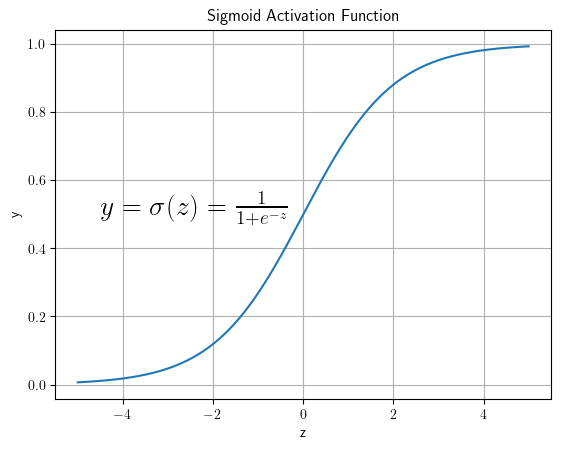

In [150]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'


def sigmoid(z):
    return 1 / (1 + np.exp(-z))

z = np.linspace(-5, 5, 1000)
y = sigmoid(z)

fig, ax = plt.subplots()
ax.plot(z, y)
ax.set_title("Sigmoid Activation Function")
ax.set_xlabel("z")
ax.set_ylabel("y")
ax.grid()

# Add LaTeX formula to the plot
formula = r"$y = \sigma (z) = \frac{1}{1 + e^{-z}}$"
ax.text(-4.5, 0.5, formula, fontsize=20)

plt.show()

Tanh Activation Function:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'


def tanh(z):
    return np.tanh(x)

z = np.linspace(-5, 5, 1000)
y = tanh(z)

fig, ax = plt.subplots()
ax.plot(z, y)
ax.set_title("Tanh Activation Function")
ax.set_xlabel("z")
ax.set_ylabel("y")
ax.grid()

# Add LaTeX formula to the plot
formula = r"$y = \sigma (z) = \frac{e^{z} - e^{-z}}{e^{z} + e^{-z}}$"
ax.text(-4.5, 0.5, formula, fontsize=22)

plt.show()

ReLU Activation Function:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'


def relu(z):
    return np.maximum(0, z)

z = np.linspace(-5, 5, 1000)
y = relu(z)

fig, ax = plt.subplots()
ax.plot(z, y)
ax.set_title("Relu Activation Function")
ax.set_xlabel("z")
ax.set_ylabel("y")
ax.grid()

# Add LaTeX formula to the plot
formula = r"$y = \sigma (z) = \max(0,z)$"
ax.text(-4.5, 2.2, formula, fontsize=22)

plt.show()

LeakyReLU Activation Function:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'


def leaky_relu(z, alpha=0.1):
    return np.where(z > 0, z, alpha * z)

z = np.linspace(-5, 5, 1000)
y = leaky_relu(z)

fig, ax = plt.subplots()
ax.plot(z, y)
ax.set_title("LeakyReLU Activation Function")
ax.set_xlabel("z")
ax.set_ylabel("y")
ax.grid()

# Add LaTeX formula to the plot
formula = r"$y = \sigma (z) = \begin{cases} x, & \text{if } x > 0 \\ \alpha x, & \text{if } x \leq 0 \end{cases}$"
ax.text(-4.5, 1, formula, fontsize=14)

plt.show()

ELU Activation Function:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'


def elu(z, alpha=1.0):
    return np.where(z > 0, z, alpha * (np.exp(z) - 1))

z = np.linspace(-5, 5, 1000)
y = elu(z)

fig, ax = plt.subplots()
ax.plot(z, y)
ax.set_title("ELU Activation Function")
ax.set_xlabel("z")
ax.set_ylabel("y")
ax.grid()

# Add LaTeX formula to the plot
formula = r"$y = \sigma (z) = \begin{cases} z, & \text{if } z > 0 \\ \alpha(e^z-1), & \text{if } z \leq 0 \end{cases}$"
ax.text(-4.5, 2, formula, fontsize=14)

plt.show()


In [ ]:
from IPython.display import display, Math

# display(Math(r""))
display(Math(r"\mathcal{L}(y, \hat{y}) = \frac{1}{n} \sum_{i=1}^n (y_i - \hat{y}_i)^2"))
display(Math(r"m \leftarrow \beta_1 \cdot m + (1-\beta_1) \cdot \frac{\partial \mathcal{L}}{\partial w^2_{1,1}}"))
display(Math(r"v \leftarrow \beta_2 \cdot v + (1-\beta_2) \cdot (\frac{\partial \mathcal{L}}{\partial w^2_{1,1}})^2"))
display(Math(r"w^2_{1,1} \leftarrow w^2_{1,1} - \eta \cdot \frac{m}{\sqrt{v}}"))
display(Math(r"w^2_{1,1} \leftarrow w^2_{1,1} - \eta \cdot \frac{\partial \mathcal{L}}{\partial w^2_{1,1}}"))

In [240]:
M = 4                  ####modulation order, 4 for 4qam, 16 for 16qam

constellation = np.linspace(int(-np.sqrt(M) + 1), int(np.sqrt(M) - 1), int(np.sqrt(M)))
print('constellation =', constellation)
alpha = np.sqrt((constellation ** 2).mean())
print('alpha =', alpha)
constellation /= (alpha * np.sqrt(2))
print('constellation =', constellation)
        

constellation = [-1.  1.]
alpha = 1.0
constellation = [-0.70710678  0.70710678]


In [3]:
class DeepImagePrior(object):

    def __init__(self,user_num,M, iteration,LR,buffer_size,threshold,stop):
        
        self.user_num = user_num    ####number of transmitted symbol in real domain
        self.M = M                  ####modulation order, 4 for 4qam, 16 for 16qam
        self.iteration = iteration  ####number of max iterations used for DIP
        self.LR = LR                ####Learning rate,  typically set to 0.01; 
                                    ####Control step size of updating the model parameters at each iteration
        self.buffer_size = buffer_size    ###iterations stored,  typically set to 30
        self.threshold = threshold        ###Threshold of DIP stop,, typically set to 0.001
        self.stop = stop                  ###True
        
        constellation = np.linspace(int(-np.sqrt(M) + 1), int(np.sqrt(M) - 1), int(np.sqrt(M)))

        alpha = np.sqrt((constellation ** 2).mean())

        constellation /= (alpha * np.sqrt(2))
        print('constellation =', constellation)
        self.constellation = constellation

        constellation_expanded = np.expand_dims(self.constellation, axis=1)

        constellation_expanded= np.repeat(constellation_expanded[None,...],1,axis=0)

        constellation_expanded_transpose = np.repeat(constellation_expanded.transpose(0,2,1), self.user_num, axis=1)

        self.constellation_expanded =torch.from_numpy(constellation_expanded)

        self.constellation_expanded_transpose = torch.from_numpy(constellation_expanded_transpose)

    def QAM_const(self):
        mod_n = self.M
        sqrt_mod_n = np.int(np.sqrt(mod_n))
        real_qam_consts = np.empty((mod_n), dtype=np.int64)
        # print('real_qam_consts =', real_qam_consts)
        imag_qam_consts = np.empty((mod_n), dtype=np.int64)
        # print('imag_qam_consts =', imag_qam_consts)
        for i in range(sqrt_mod_n):
            for j in range(sqrt_mod_n):
                    index = sqrt_mod_n*i + j
                    real_qam_consts[index] = i
                    imag_qam_consts[index] = j
        print('real_qam_consts =', real_qam_consts)
        print('imag_qam_consts =', imag_qam_consts)
        a = self.constellation[real_qam_consts]
        b = self.constellation[imag_qam_consts]
        return(a, b)

# Deep Image Prior
dip = DeepImagePrior(user_num=NUM_RX_ANT,      # Number of transmitted symbol in real domain
                    M=16,              # Modulation order, 4 for 4qam, 16 for 16qam
                    iteration=100,    # Number of max iterations used for DIP: 100
                    LR=0.01,          # Learning rate,  typically set to 0.01
                    buffer_size=30,   # Iterations stored,  typically set to 30
                    threshold=0.001,  # Threshold of DIP stop,, typically set to 0.001
                    stop=True)        # True

# print(dip.QAM_const())
dip.QAM_const()


NameError: name 'np' is not defined

In [31]:
import numpy as np
import tensorflow as tf
# For the implementation of the Keras models
from tensorflow.keras.layers import Layer


NUM_TX_ANT = 4
y = tf.constant([[1+1j,1-1j,1+1j,1-1j,1+1j,1-1j,1+1j,1-1j,1+1j,1-1j,1+1j,1-1j,1+1j,1-1j,1+1j,1-1j],[1+1j,1-1j,1+1j,1-1j,1+1j,1-1j,1+1j,1-1j,1+1j,1-1j,1+1j,1-1j,1+1j,1-1j,1+1j,1-1j]]);
print('y =',y)
# y_reshape_1row = tf.reshape(y,shape=[1,-1])
# print('x_reshape_1row =',x_reshape_1row)
# y_reshape_2col4row = tf.reshape(y,shape=[-1,NUM_TX_ANT])
# print('y_reshape_2col4row =',y_reshape_2col4row)
# y_reshape_1col = tf.transpose(y)
# print('y_reshape_1col =',y_reshape_1col)
shape_y = tf.shape(y)
# print('shape_y =',shape_y)
y_reshape_1col = tf.reshape(y,shape=[-1,1])
# print('y_reshape_1col =',y_reshape_1col)

# y_channel = tf.expand_dims(y_reshape_2col4row, axis=-1)
# print('y_channel =',y_channel)

# hdd = [];

y_reshape_1col_real_part = tf.math.real(y_reshape_1col);
# print('y_reshape_1col_real_part =',y_reshape_1col_real_part)
y_reshape_1col_imag_part = tf.math.imag(y_reshape_1col);
# print('y_reshape_1col_imag_part =',y_reshape_1col_imag_part)
y_reshape_1col_real = tf.concat([y_reshape_1col_real_part, y_reshape_1col_imag_part], axis=1) #(batch,168)
print('y_reshape_1col_real =',y_reshape_1col_real)

# y_reshape_2col4row_real_part = tf.math.real(y_reshape_2col4row);
# print('y_real_part =',y_reshape_2col4row_real_part)
# y_reshape_2col4row_imag_part = tf.math.imag(y_reshape_2col4row);
# print('y_imag_part =',y_reshape_2col4row_imag_part)

# y_reshape_2col4row_real = tf.concat([y_reshape_2col4row_real_part, y_reshape_2col4row_imag_part], axis=1) # (batch,158), axis=1(Second Diomension)
# print('y_reshape_real =',y_reshape_2col4row_real)

# y_reshape_1col_real_part = tf.math.real(y_reshape_1col);
# print('y_reshape_1col_real_part =',y_reshape_1col_real_part)
# y_reshape_1col_imag_part = tf.math.imag(y_reshape_1col);
# print('y_reshape_1col_imag_part =',y_reshape_1col_imag_part)

# y_reshape_real = tf.concat([y_reshape_1col_real_part, y_reshape_1col_imag_part], axis=1) # (batch,158), axis=1(Second Diomension)
# print('y_reshape_real =',y_reshape_real)


# y_real_part = np.real(y);
# y_imag_part = np.imag(y);
# y_real = np.concatenate([y_real_part, y_imag_part], axis=1) #(batch,168)
# Hr = np.real(hdd);
# Hi = np. imag(hdd);
# hdd_real = np.concatenate([np.concatenate([Hr, -Hi], axis=2), np.concatenate([Hi, Hr], axis=2)],axis=1)

y = tf.Tensor(
[[1.+1.j 1.-1.j 1.+1.j 1.-1.j 1.+1.j 1.-1.j 1.+1.j 1.-1.j 1.+1.j 1.-1.j
  1.+1.j 1.-1.j 1.+1.j 1.-1.j 1.+1.j 1.-1.j]
 [1.+1.j 1.-1.j 1.+1.j 1.-1.j 1.+1.j 1.-1.j 1.+1.j 1.-1.j 1.+1.j 1.-1.j
  1.+1.j 1.-1.j 1.+1.j 1.-1.j 1.+1.j 1.-1.j]], shape=(2, 16), dtype=complex128)
y_reshape_1col_real = tf.Tensor(
[[ 1.  1.]
 [ 1. -1.]
 [ 1.  1.]
 [ 1. -1.]
 [ 1.  1.]
 [ 1. -1.]
 [ 1.  1.]
 [ 1. -1.]
 [ 1.  1.]
 [ 1. -1.]
 [ 1.  1.]
 [ 1. -1.]
 [ 1.  1.]
 [ 1. -1.]
 [ 1.  1.]
 [ 1. -1.]
 [ 1.  1.]
 [ 1. -1.]
 [ 1.  1.]
 [ 1. -1.]
 [ 1.  1.]
 [ 1. -1.]
 [ 1.  1.]
 [ 1. -1.]
 [ 1.  1.]
 [ 1. -1.]
 [ 1.  1.]
 [ 1. -1.]
 [ 1.  1.]
 [ 1. -1.]
 [ 1.  1.]
 [ 1. -1.]], shape=(32, 2), dtype=float64)
X = tf.Tensor(
[[1.+1.j]
 [2.+2.j]
 [3.+3.j]], shape=(3, 1), dtype=complex128)
H = tf.Tensor(
[[ 1. +2.j  3. +4.j  5. +6.j]
 [ 7. +8.j  9.+10.j 11.+12.j]
 [13.+14.j 15.+16.j 17.+18.j]], shape=(3, 3), dtype=complex128)
Y = tf.Tensor(
[[-6. +50.j]
 [-6.+122.j]
 [-6.+194.j]], shape=(3, 1), dtype=compl

In [2]:
import numpy as np
import tensorflow as tf
# For the implementation of the Keras models
from tensorflow.keras.layers import Layer

BATCH_SIZE = 1
NUM_RX_ANT = 3
NUM_TX_ANT = 3
X = tf.constant([[1+2j],[3+4j],[5+6j]])
print('X =',X)
H = tf.constant([[1+2j,3+4j,5+6j],[7+8j,9+10j,11+12j],[13+14j,15+16j,17+18j]])
print('H =',H)
H_shape = tf.shape(H)
# print('H_shape =',H_shape)
Y = tf.matmul(H, X)
print('Y =',Y)

X_real_part = tf.math.real(X);
# print('X_real_part =',X_real_part)
X_imag_part = tf.math.imag(X);
# print('X_imag_part =',X_imag_part)
X_real = tf.concat([X_real_part, X_imag_part], axis=1)
# print('X_real =',X_real)
e = tf.reshape(X_real,[BATCH_SIZE,NUM_TX_ANT,2,1]) # [BATCH_SIZE,NUM_TX_ANT,2,1] = [1,-1,2,1]
# print('e =',e)
repeat_times = NUM_RX_ANT
f = tf.repeat(e, repeat_times, axis=0)
# print('f =',f)

Y_real_part = tf.math.real(Y);
# print('Y_real_part =',Y_real_part)
Y_imag_part = tf.math.imag(Y);
# print('Y_imag_part =',Y_imag_part)
Y_real = tf.concat([Y_real_part, Y_imag_part], axis=1)
# print('Y_real =',Y_real)

H_Reshaped = tf.reshape(H,[-1,1])
# print('H_Reshaped =',H_Reshaped)
H_Reshaped_real_part = tf.math.real(H_Reshaped);
# print('H_Reshaped_real_part =',H_Reshaped_real_part)
H_Reshaped_imag_part = tf.math.imag(H_Reshaped);
# print('H_Reshaped_imag_part =',H_Reshaped_imag_part);

H_real_part_Reshaped = tf.reshape(H_Reshaped_real_part,[1,-1,1])
# print('H_real_part_Reshaped =',H_real_part_Reshaped)
H_imag_part_Reshaped = tf.reshape(H_Reshaped_imag_part,[1,-1,1])
# print('H_imag_part_Reshaped =',H_imag_part_Reshaped)

b = tf.concat([H_real_part_Reshaped, -H_imag_part_Reshaped], axis=2)
# print('b =',b)
c = tf.concat([H_imag_part_Reshaped, H_real_part_Reshaped], axis=2)
# print('c =',c)
b_trans = tf.transpose(b, (1, 0, 2))
# print('b_trans =',b_trans)
c_trans = tf.transpose(c, (1, 0, 2))
# print('c_trans =',c_trans)
d = tf.concat([b_trans, c_trans], axis=1)
# print('d =',d)
g = tf.reshape(d,[3,3,2,2]) # [NUM_RX_ANT,NUM_TX_ANT,2,2] = [3,3,2,2]
# print('g =',g)
# H_Reshaped_real = tf.concat([tf.concat([H_real_part_Reshaped, -H_imag_part_Reshaped], axis=2), tf.concat([H_imag_part_Reshaped, H_real_part_Reshaped], axis=2)],axis=1)
result = tf.matmul(g, f)
# print('result =',result)
sum = tf.reduce_sum(result, axis=1)
# print('sum =',sum)
sum_real,sum_imag = tf.split(sum, num_or_size_splits=2, axis=1)
# print('sum_real =',sum_real)
# print('sum_imag =',sum_imag)
sum_complex = tf.squeeze(tf.complex(sum_real,sum_imag),axis=-1)
print('sum_complex =',sum_complex)
if all(Y == sum_complex):
    print('Y = sum_complex!!!')

X = tf.Tensor(
[[1.+2.j]
 [3.+4.j]
 [5.+6.j]], shape=(3, 1), dtype=complex128)
H = tf.Tensor(
[[ 1. +2.j  3. +4.j  5. +6.j]
 [ 7. +8.j  9.+10.j 11.+12.j]
 [13.+14.j 15.+16.j 17.+18.j]], shape=(3, 3), dtype=complex128)
Y = tf.Tensor(
[[-21. +88.j]
 [-39.+214.j]
 [-57.+340.j]], shape=(3, 1), dtype=complex128)
sum_complex = tf.Tensor(
[[-21. +88.j]
 [-39.+214.j]
 [-57.+340.j]], shape=(3, 1), dtype=complex128)
Y = sum_complex!!!


BATCH_SIZE

In [9]:
import numpy as np
import tensorflow as tf
# For the implementation of the Keras models
from tensorflow.keras.layers import Layer

BATCH_SIZE = 2
NUM_RX_ANT = 3
NUM_TX_ANT = 3
X = tf.constant([[[1+2j],[3+4j],[5+6j]],[[1+2j],[3+4j],[5+6j]]])
print('X =',X)
H = tf.constant([[[1+2j,3+4j,5+6j],[7+8j,9+10j,11+12j],[13+14j,15+16j,17+18j]],[[1+2j,3+4j,5+6j],[7+8j,9+10j,11+12j],[13+14j,15+16j,17+18j]]])
print('H =',H)
H_shape = tf.shape(H)
# print('H_shape =',H_shape)
# print('BATCH_SIZE =',H.shape[0])
Y = tf.matmul(H, X)
print('Y =',Y)

X_real_part = tf.math.real(X);
# print('X_real_part =',X_real_part)
X_imag_part = tf.math.imag(X);
# print('X_imag_part =',X_imag_part)
X_temp_real = tf.concat([X_real_part, X_imag_part], axis=2)
# print('X_real =',X_real)
e = tf.reshape(X_temp_real,[BATCH_SIZE,NUM_TX_ANT,2,1]) # [BATCH_SIZE,NUM_TX_ANT,2,1] = [1,-1,2,1]
print('e =',e)
# X_fake_real = tf.repeat(e, repeats=NUM_RX_ANT, axis=0)
# print('X_fake_real =',X_fake_real)
X_real = tf.reshape(tf.repeat(e, repeats=NUM_RX_ANT, axis=0),[BATCH_SIZE,NUM_RX_ANT,NUM_TX_ANT,2,1])
print('X_real =',X_real)

Y_real_part = tf.math.real(Y);
# print('Y_real_part =',Y_real_part)
Y_imag_part = tf.math.imag(Y);
# print('Y_imag_part =',Y_imag_part)
Y_real_part_reshaped = tf.reshape(Y_real_part,[BATCH_SIZE,NUM_RX_ANT,1,1])
# print('Y_real_part_reshaped =',Y_real_part_reshaped)
Y_imag_part_reshaped = tf.reshape(Y_imag_part,[BATCH_SIZE,NUM_RX_ANT,1,1])
# print('Y_imag_part_reshaped =',Y_imag_part_reshaped)
Y_real = tf.concat([Y_real_part_reshaped, Y_imag_part_reshaped], axis=2)
print('Y_real =',Y_real)

H_Reshaped = tf.reshape(H,[BATCH_SIZE,-1,1])
# print('H_Reshaped =',H_Reshaped)
H_Reshaped_real_part = tf.math.real(H_Reshaped);
# print('H_Reshaped_real_part =',H_Reshaped_real_part)
H_Reshaped_imag_part = tf.math.imag(H_Reshaped);
# print('H_Reshaped_imag_part =',H_Reshaped_imag_part);

H_real_part_Reshaped = tf.reshape(H_Reshaped_real_part,[BATCH_SIZE,-1,1])
# print('H_real_part_Reshaped =',H_real_part_Reshaped)
H_imag_part_Reshaped = tf.reshape(H_Reshaped_imag_part,[BATCH_SIZE,-1,1])
# print('H_imag_part_Reshaped =',H_imag_part_Reshaped)

b = tf.concat([H_real_part_Reshaped, -H_imag_part_Reshaped], axis=2)
# print('b =',b)
c = tf.concat([H_imag_part_Reshaped, H_real_part_Reshaped], axis=2)
# print('c =',c)
b_trans = tf.reshape(b, [BATCH_SIZE, NUM_RX_ANT*NUM_TX_ANT, -1, 2])
# print('b_trans =',b_trans)
c_trans = tf.reshape(c, [BATCH_SIZE, NUM_RX_ANT*NUM_TX_ANT, -1, 2])
# print('c_trans =',c_trans)
d = tf.concat([b_trans, c_trans], axis=2)
# print('d =',d)
H_real = tf.reshape(d,[BATCH_SIZE,NUM_RX_ANT,NUM_TX_ANT,2,2])
print('H_real =',H_real)

H_bs1_1166 = tf.reshape(H_real[1],[1,1,2*NUM_RX_ANT,2*NUM_TX_ANT])
print('H_bs1_1166 =',H_bs1_1166)
X_bs1_1161 = tf.reshape(X_real[1],[1,1,2*NUM_TX_ANT,3])
print('X_bs1_1161 =',X_bs1_1161)
Y_bs1_1161 = tf.matmul(H_bs1_1166, X_bs1_1161)
print('Y_bs1_1161 =',Y_bs1_1161)

# H_Reshaped_real = tf.concat([tf.concat([H_real_part_Reshaped, -H_imag_part_Reshaped], axis=2), tf.concat([H_imag_part_Reshaped, H_real_part_Reshaped], axis=2)],axis=1)
result = tf.matmul(H_real, X_real)
print('result =',result)
sum = tf.reduce_sum(result, axis=2)
print('sum =',sum)
sum_real_part,sum_imag_part = tf.split(sum, num_or_size_splits=2, axis=2)
# print('sum_real =',sum_real)
# print('sum_imag =',sum_imag)
sum_complex = tf.squeeze(tf.complex(sum_real_part,sum_imag_part),axis=-1)
# print('sum_complex =',sum_complex)
if tf.reduce_all(tf.equal(Y,sum_complex)):
    print('Y = sum_complex!!!')

X = tf.Tensor(
[[[1.+2.j]
  [3.+4.j]
  [5.+6.j]]

 [[1.+2.j]
  [3.+4.j]
  [5.+6.j]]], shape=(2, 3, 1), dtype=complex128)
H = tf.Tensor(
[[[ 1. +2.j  3. +4.j  5. +6.j]
  [ 7. +8.j  9.+10.j 11.+12.j]
  [13.+14.j 15.+16.j 17.+18.j]]

 [[ 1. +2.j  3. +4.j  5. +6.j]
  [ 7. +8.j  9.+10.j 11.+12.j]
  [13.+14.j 15.+16.j 17.+18.j]]], shape=(2, 3, 3), dtype=complex128)
Y = tf.Tensor(
[[[-21. +88.j]
  [-39.+214.j]
  [-57.+340.j]]

 [[-21. +88.j]
  [-39.+214.j]
  [-57.+340.j]]], shape=(2, 3, 1), dtype=complex128)
e = tf.Tensor(
[[[[1.]
   [2.]]

  [[3.]
   [4.]]

  [[5.]
   [6.]]]


 [[[1.]
   [2.]]

  [[3.]
   [4.]]

  [[5.]
   [6.]]]], shape=(2, 3, 2, 1), dtype=float64)
X_real = tf.Tensor(
[[[[[1.]
    [2.]]

   [[3.]
    [4.]]

   [[5.]
    [6.]]]


  [[[1.]
    [2.]]

   [[3.]
    [4.]]

   [[5.]
    [6.]]]


  [[[1.]
    [2.]]

   [[3.]
    [4.]]

   [[5.]
    [6.]]]]



 [[[[1.]
    [2.]]

   [[3.]
    [4.]]

   [[5.]
    [6.]]]


  [[[1.]
    [2.]]

   [[3.]
    [4.]]

   [[5.]
    [6.]]]



In [21]:
import torch
dtype = torch.FloatTensor

BATCH_SIZE = 2
NUM_RX_ANT = 3
NUM_TX_ANT = 3
X = torch.tensor([[[1+2j],[3+4j],[5+6j]],[[1+2j],[3+4j],[5+6j]]])
print('X =',X)
X_real_part = torch.real(X);
# print('X_real_part =',X_real_part)
X_imag_part = torch.imag(X);
# print('X_imag_part =',X_imag_part)
X_temp_real = torch.cat([X_real_part, X_imag_part], dim=2)
# print('X_real =',X_real)
e = torch.reshape(X_temp_real,[BATCH_SIZE,NUM_TX_ANT,2,1]) # [BATCH_SIZE,NUM_TX_ANT,2,1] = [1,-1,2,1]
print('e =',e)
print('e shape =',e.shape)
X_real = torch.reshape(e.repeat(NUM_RX_ANT,1,1,1),[BATCH_SIZE,NUM_RX_ANT,NUM_TX_ANT,2,1])
print('X_real shape =',X_real.shape)
print('X_real =',X_real)


X = tensor([[[1.+2.j],
         [3.+4.j],
         [5.+6.j]],

        [[1.+2.j],
         [3.+4.j],
         [5.+6.j]]])
e = tensor([[[[1.],
          [2.]],

         [[3.],
          [4.]],

         [[5.],
          [6.]]],


        [[[1.],
          [2.]],

         [[3.],
          [4.]],

         [[5.],
          [6.]]]])
e shape = torch.Size([2, 3, 2, 1])
X_real shape = torch.Size([2, 3, 3, 2, 1])
X_real = tensor([[[[[1.],
           [2.]],

          [[3.],
           [4.]],

          [[5.],
           [6.]]],


         [[[1.],
           [2.]],

          [[3.],
           [4.]],

          [[5.],
           [6.]]],


         [[[1.],
           [2.]],

          [[3.],
           [4.]],

          [[5.],
           [6.]]]],



        [[[[1.],
           [2.]],

          [[3.],
           [4.]],

          [[5.],
           [6.]]],


         [[[1.],
           [2.]],

          [[3.],
           [4.]],

          [[5.],
           [6.]]],


         [[[1.],
           

In [18]:
import torch

x = torch.randn(1, 3, 2, 1)
y = x.repeat(3, 1, 1, 1)
print(x)
print(y)


tensor([[[[ 1.1937],
          [ 0.3977]],

         [[ 0.5643],
          [-0.4291]],

         [[-0.6503],
          [-0.1561]]]])
tensor([[[[ 1.1937],
          [ 0.3977]],

         [[ 0.5643],
          [-0.4291]],

         [[-0.6503],
          [-0.1561]]],


        [[[ 1.1937],
          [ 0.3977]],

         [[ 0.5643],
          [-0.4291]],

         [[-0.6503],
          [-0.1561]]],


        [[[ 1.1937],
          [ 0.3977]],

         [[ 0.5643],
          [-0.4291]],

         [[-0.6503],
          [-0.1561]]]])


[]
[[10  2  3]
 [ 4  5  6]
 [ 7  8  9]]
[7. 5. 6.]
[-5.  -2.5  0.   2.5  5.   7.5 10.  12.5 15.  17.5 20. ]


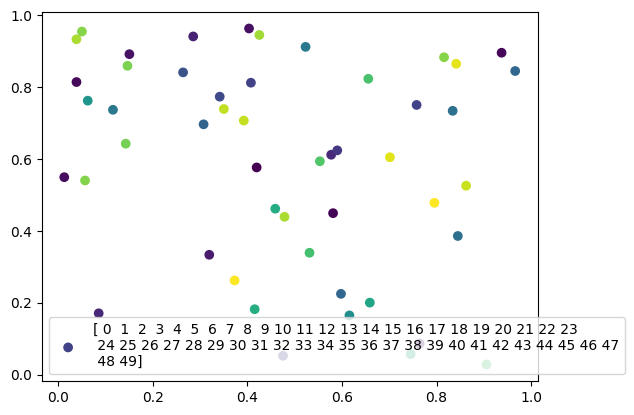

In [1]:
import numpy as np

# 生成一个二维空数组
arr = np.empty((0, 0))

print(arr)

arr = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])

# 对二维数组的某个位置元素赋值
row_index = 0  # 要赋值的行索引
col_index = 0  # 要赋值的列索引
value = 10  # 要赋的值

arr[row_index, col_index] = value

print(arr)


column_means = np.mean(arr, axis=0)
print(column_means)

print(np.linspace(-5,20,11))

import numpy as np
import matplotlib.pyplot as plt

# 生成示例数据
x = np.random.rand(50)
y = np.random.rand(50)
colors = np.random.rand(50)
labels = np.arange(50)

# 绘制散点图
plt.scatter(x, y, c=colors, label=labels)

# 设置图例
plt.legend()

# 显示图像
plt.show()


Number of GPUs available : 0
Data Group 0
Processing...
Done


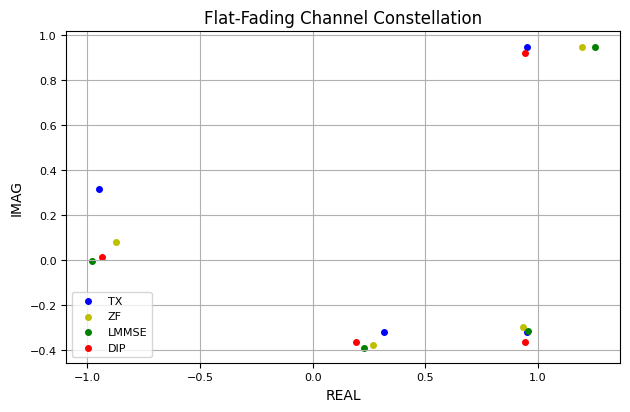

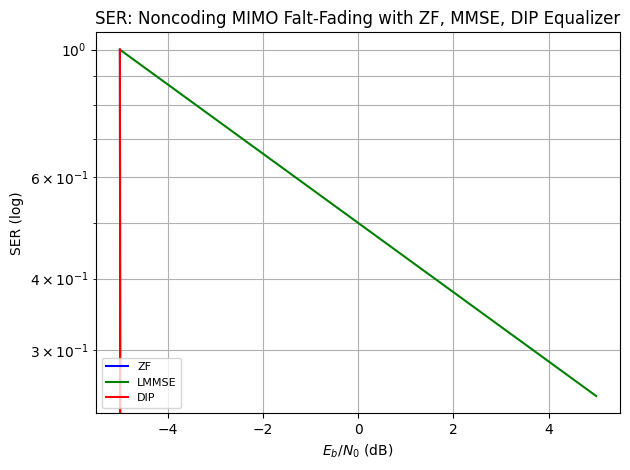

In [77]:
import tensorflow as tf
# For the implementation of the Keras models
from tensorflow import keras
from keras import Model
# for performance measurements
import time

# GPU Configuration and Imports
# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
gpus = tf.config.list_physical_devices('GPU')
print('Number of GPUs available :', len(gpus))
if gpus:
    gpu_num = 0 # Number of the GPU to be used
    try:
        tf.config.set_visible_devices(gpus[gpu_num], 'GPU')
        print('Only GPU number', gpu_num, 'used.')
        tf.config.experimental.set_memory_growth(gpus[gpu_num], True)
    except RuntimeError as e:
        print(e)

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sys

# Import Sionna
try:
    import sionna as sn
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna as sn
    
from sionna.utils import BinarySource, QAMSource, ebnodb2no, compute_ser, compute_ber, PlotBER
from sionna.channel import FlatFadingChannel, KroneckerModel
from sionna.channel.utils import exp_corr_mat
from sionna.mimo import lmmse_equalizer, zf_equalizer
from sionna.mapping import SymbolDemapper, Mapper, Demapper
from sionna.fec.ldpc.encoding import LDPC5GEncoder
from sionna.fec.ldpc.decoding import LDPC5GDecoder
from sionna.utils.misc import hard_decisions
from sionna.utils.metrics import compute_ber
from xyDIP import DeepImagePrior
from complex2real import Complex2Real

k = 4 # Block Length:512
NUM_TX_ANT = 4 # Transmit Antennas: 4
NUM_RX_ANT = 4 # Receive Antennas: 4
NUM_BITS_PER_SYMBOL = 4 # Mapping: 16QAM
BATCH_SIZE = 1 # Numerbe of Parallelly Processed Batches: 32
EBN0_DB_MIN = -5.0 # Minimum Eb/N0 (dB): -5
EBN0_DB_MAX = 5.0 # Maximum Eb/N0 (dB): 20
NUM_EBN0_POINTS = 2 # EBNO Points: 11
NUM_DATA_GROUP = 1

snrs = np.linspace(EBN0_DB_MIN,EBN0_DB_MAX,NUM_EBN0_POINTS)
bers = []
sers_zf = np.empty((NUM_DATA_GROUP, NUM_EBN0_POINTS))
sers_lmmse = np.empty((NUM_DATA_GROUP, NUM_EBN0_POINTS))
sers_dip = np.empty((NUM_DATA_GROUP, NUM_EBN0_POINTS))

# Binary Source
binary_source = sn.utils.BinarySource()

# Constellation
constellation = sn.mapping.Constellation("qam", NUM_BITS_PER_SYMBOL)
#constellation.show(figsize=(7,7));

# Mapper and Demapper
mapper = sn.mapping.Mapper(constellation=constellation)
# The demapper uses the same constellation object as the mapper
demapper = sn.mapping.Demapper("app", constellation=constellation)

# AWGN Channel
awgn_channel = sn.channel.AWGN()

# Flat Fading Channel
# To simulate transmissions over an i.i.d. Rayleigh fading channel. The channel will also add AWGN with variance `no`.
flatfading_channel = FlatFadingChannel(NUM_TX_ANT, NUM_RX_ANT, add_awgn=True, return_channel=True)

# SymbolDemapper
symbol_demapper = SymbolDemapper("qam", NUM_BITS_PER_SYMBOL, hard_out=True)

# Deep Image Prior
dip = DeepImagePrior(num_rx_ant=NUM_RX_ANT,
                    num_tx_ant=NUM_TX_ANT,      # Number of transmitted symbol in real domain
                    M=16,              # Modulation order, 4 for 4QAM, 16 for 16QAM; 16QAM: 4 bits per symbol
                    iteration=100,    # Number of max iterations used for DIP: 100
                    LR=0.01,          # Learning rate,  typically set to 0.01
                    buffer_size=30,   # Iterations stored,  typically set to 30
                    threshold=0.001,  # Threshold of DIP stop,, typically set to 0.001
                    stop=True)        # True

# Complex2Real
c2r = Complex2Real(NUM_RX_ANT,NUM_TX_ANT)

for i in range(0, NUM_DATA_GROUP):

    print('Data Group {}'.format(i))
    print('Processing...')

    b = binary_source([BATCH_SIZE,NUM_TX_ANT,k])
    # print('b shape =',b.shape)

    x = mapper(b)
    # print('x shape =',x.shape)
    # print('x =',x)

    shape = tf.shape(x)
    x_reshape = tf.reshape(x,[-1, NUM_TX_ANT])
    # print('x reshape =',x_reshape.shape)
    # print('x_reshape =',x_reshape)

    # Tx_Symbols = bits2symbol(b,NUM_BITS_PER_SYMBOL)
    # print('Tx_Symbols =',Tx_Symbols)
    
    j = 0
    
    for EBN0_DB in np.linspace(EBN0_DB_MIN,EBN0_DB_MAX,NUM_EBN0_POINTS):
        
        # print('EBN0_DB =',EBN0_DB)

        no = sn.utils.ebnodb2no(ebno_db=EBN0_DB,
                                num_bits_per_symbol=NUM_BITS_PER_SYMBOL,
                                coderate=1.0) # Coderate set to 1 as we do uncoded transmission here
        # print('no =',no)

        x_ind = symbol_demapper([x, no])
        # print('x_ind.shape =',x_ind.shape)
        # print('x_ind =',x_ind)

        # y and h are the Channel Output and Channel Realizations, respectively.
        y, h = flatfading_channel([x_reshape, no])
        # print('h.shape =\n',h.shape)
        # print('y.shape =\n',y.shape)

        s = tf.cast(no*tf.eye(NUM_RX_ANT, NUM_RX_ANT), y.dtype)

        x_hat_zf, no_eff_zf = zf_equalizer(y, h, s)
        # print('x_hat_zf.shape =',x_hat_zf.shape)
        # print('x_hat_zf =',x_hat_zf)
        x_hat_lmmse, no_eff_lmmse = lmmse_equalizer(y, h, s)
        # print('x_hat_lmmse.shape =',x_hat_lmmse.shape)

        X_inCH_real,H_real,Y_real = c2r.C2R(x_reshape,h,y)
        # print('X_inCH_real =',X_inCH_real)
        # print('max =',np.max(X_inCH_real))
        # print('H_real =',H_real)
        # print('Y_real =',Y_real)

        x_dip_ay,num_stop_point = dip.DIP(Y_real,H_real)
        # print('x_dip_ay.shape =',x_dip_ay.shape)
        # print('x_dip =',x_dip_ay)
        # print('num_stop_point =',num_stop_point)
        x_dip_ay_real_part,x_dip_ay_imag_part = tf.split(x_dip_ay, num_or_size_splits=2, axis=2)
        # print('sum_real =',sum_real)
        # print('sum_imag =',sum_imag)
        x_hat_dip = tf.squeeze(tf.squeeze(tf.complex(x_dip_ay_real_part,x_dip_ay_imag_part),axis=-1),axis=-1)
        # print('x_hat_dip =',x_hat_dip)

        x_hat_zf = tf.reshape(x_hat_zf, shape)
        # print('x_hat_zf.shape =',x_hat_zf.shape)
        x_hat_lmmse = tf.reshape(x_hat_lmmse, shape)
        # print('x_hat_lmmse.shape =',x_hat_lmmse.shape)
        x_hat_dip = tf.reshape(x_hat_dip, shape)
        # print('x_hat_lmmse.shape =',x_hat_lmmse.shape)

        # no_eff_zf = tf.reshape(no_eff_zf, shape)
        # no_eff_lmmse = tf.reshape(no_eff_lmmse, shape)

        # llr_zf = demapper([x_hat_zf, no_eff_zf])
        # b_hat_zf = decoder(llr_zf)

        x_ind_hat_zf = symbol_demapper([x_hat_zf, no])
        # print('x_ind_hat_zf.shape =',x_ind_hat_zf.shape)
        # print('x_ind_hat_zf =',x_ind_hat_zf)
        x_ind_hat_lmmse = symbol_demapper([x_hat_lmmse, no])
        # print('x_ind_hat_lmmse.shape =',x_ind_hat_lmmse.shape)
        x_ind_hat_dip = symbol_demapper([tf.cast(x_hat_dip, dtype=tf.complex64), no])
        # print('x_ind_hat_lmmse.shape =',x_ind_hat_lmmse.shape)

        ser_zf = compute_ser(x_ind, x_ind_hat_zf)
        ser_lmmse = compute_ser(x_ind, x_ind_hat_lmmse)
        ser_dip = compute_ser(x_ind, x_ind_hat_dip)
        sers_zf[i, j] = ser_zf
        sers_lmmse[i, j] = ser_lmmse
        sers_dip[i, j] = ser_dip

        j = j+1
    print('Done')

sers_zf_mean = np.mean(sers_zf, axis=0)
sers_lmmse_mean = np.mean(sers_lmmse, axis=0)
sers_dip_mean = np.mean(sers_dip, axis=0)

plt.figure(1)
plt.axes().set_aspect(1)
plt.grid(True)
plt.title('Flat-Fading Channel Constellation', fontsize=12)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel('REAL', fontsize=10)
plt.ylabel('IMAG', fontsize=10)
plt.scatter(tf.math.real(x), tf.math.imag(x), s=16, c='b', label='TX')
plt.scatter(tf.math.real(x_hat_zf), tf.math.imag(x_hat_zf), s=16, c='y', label='ZF')
plt.scatter(tf.math.real(x_hat_lmmse), tf.math.imag(x_hat_lmmse), s=16, c='g', label='LMMSE')
plt.scatter(tf.math.real(x_hat_dip), tf.math.imag(x_hat_dip), s=16, c='r', label='DIP')
plt.legend(loc='lower left', fontsize=8)
plt.tight_layout()

plt.figure(2)
title = "SER: Noncoding MIMO Falt-Fading with ZF, MMSE, DIP Equalizer"
xlabel = "$E_b/N_0$ (dB)"
ylabel = "SER (log)"
plt.title(title, fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel(xlabel, fontsize=10)
plt.ylabel(ylabel, fontsize=10)
plt.grid(which="both")
plt.semilogy(snrs, sers_zf_mean, 'b', label='ZF')
plt.semilogy(snrs, sers_lmmse_mean, 'g', label='LMMSE')
plt.semilogy(snrs, sers_dip_mean, 'r', label='DIP')
plt.legend(loc='lower left', fontsize=8)
plt.tight_layout()

plt.show()